In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

import os
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
DATA_PATH = os.path.join(os.getcwd(), 'food11')
TEST_PATH = os.path.join(DATA_PATH, 'test')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'validation')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class FoodDataset(Dataset):
    def __init__(self, path, transformations=None, train=True, normalize=None):
        self.path = path
        self.transformations = transformations
        self.train = train
        self.samples = []
        self.normalize = normalize

        for i, label in enumerate(os.listdir(path)):
            label_path = os.path.join(path, label)
            for img in os.listdir(label_path):
                self.samples.append((os.path.join(label_path, img), i))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        
        if self.transformations:
            img = self.transformations(img)
        return img, label

def calculate_dataset_stats(dataset_loader):
    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_pixels = 0

    print("Calculating dataset statistics...")
    for images, _ in tqdm(dataset_loader):
        batch_size, _, height, width = images.shape
        num_pixels += batch_size * height * width
        
        channels_sum += torch.sum(images, dim=[0, 2, 3])
        channels_squared_sum += torch.sum(images ** 2, dim=[0, 2, 3])
    
    mean = channels_sum / num_pixels
    std = torch.sqrt(channels_squared_sum / num_pixels - mean ** 2)
    
    return mean.tolist(), std.tolist()

def create_dataloaders(batch_size=32, random_seed=42):
    torch.manual_seed(random_seed)

    base_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    temp_train = FoodDataset(TRAIN_PATH, transformations=base_transform, train=True)
    temp_train_loader = DataLoader(temp_train, batch_size=batch_size, shuffle=True)

    mean, std = calculate_dataset_stats(temp_train_loader)
    print(f"Mean: {mean}, Std: {std}")

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Normalize(mean=mean, std=std),
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    train_dataset = FoodDataset(TRAIN_PATH, transformations=train_transform, train=True, normalize=(mean, std))
    test_dataset = FoodDataset(TEST_PATH, transformations=test_transform, train=False, normalize=(mean, std))
    val_dataset = FoodDataset(VAL_PATH, transformations=test_transform, train=False, normalize=(mean, std))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, val_loader

train_loader_32, test_loader_32, val_loader_32 = create_dataloaders()
train_loader_64, test_loader_64, val_loader_64 = create_dataloaders(batch_size=64)

Calculating dataset statistics...


100%|██████████| 69/69 [00:19<00:00,  3.49it/s]


Mean: [0.561248779296875, 0.4471413791179657, 0.33921748399734497], Std: [0.2641177773475647, 0.2645167112350464, 0.2688957750797272]
Calculating dataset statistics...


100%|██████████| 35/35 [00:11<00:00,  3.18it/s]

Mean: [0.5612488985061646, 0.44714123010635376, 0.3392176032066345], Std: [0.2641177773475647, 0.2645168602466583, 0.26889556646347046]


In [ ]:
class StandardCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(StandardCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool5(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
class StandardCNNwDropout(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0.5):
        super(StandardCNNwDropout, self).__init__()
        self.dropout_rate = dropout_rate
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc1 = nn.Linear(512 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool5(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity  # residual connection
        out = F.relu(out)
        
        return out

class ResidualCNN(nn.Module):
    def __init__(self, num_classes=11):
        super(ResidualCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.res_block1 = self._create_res_block(64, 128, stride=1)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.res_block2 = self._create_res_block(256, 256, stride=1)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def _create_res_block(self, in_channels, out_channels, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        return ResidualBlock(in_channels, out_channels, stride, downsample)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.res_block1(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        
        x = self.res_block2(x)
        
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
class ResidualCNNwDropout(nn.Module):
    def __init__(self, num_classes=11, dropout_rate=0.5):
        super(ResidualCNNwDropout, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.res_block1 = self._create_res_block(64, 128, stride=1)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.res_block2 = self._create_res_block(256, 256, stride=1)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout(dropout_rate)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
    def _create_res_block(self, in_channels, out_channels, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        return ResidualBlock(in_channels, out_channels, stride, downsample)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.res_block1(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        
        x = self.res_block2(x)
        
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training..."):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating..."):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions.append(predicted.cpu())
            all_labels.append(labels.cpu())
    
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_predictions, all_labels

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device=DEVICE):
    best_acc = 0.0
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Training complete! Best validation accuracy:", best_acc)
    return model

def test_model(model, test_loader, criterion, device):
    test_loss, test_acc, predicted, labels = evaluate(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    predicted = predicted.cpu()
    labels = labels.cpu()
    
    cm = confusion_matrix(labels, predicted)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return predicted, labels, cm

Epoch 1/50


Evaluating...: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Train Loss: 6.3449, Train Acc: 0.1077
Validation Loss: 2.3521, Validation Acc: 0.1345
Epoch 2/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


Train Loss: 2.3409, Train Acc: 0.1600
Validation Loss: 2.2963, Validation Acc: 0.1345
Epoch 3/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


Train Loss: 2.3254, Train Acc: 0.1641
Validation Loss: 2.2536, Validation Acc: 0.1927
Epoch 4/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s]


Train Loss: 2.2631, Train Acc: 0.2018
Validation Loss: 2.2381, Validation Acc: 0.1673
Epoch 5/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


Train Loss: 2.2166, Train Acc: 0.2055
Validation Loss: 2.2157, Validation Acc: 0.2036
Epoch 6/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.48it/s]


Train Loss: 2.1938, Train Acc: 0.2173
Validation Loss: 2.1564, Validation Acc: 0.2255
Epoch 7/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s]


Train Loss: 2.1677, Train Acc: 0.2295
Validation Loss: 2.1563, Validation Acc: 0.2218
Epoch 8/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


Train Loss: 2.1505, Train Acc: 0.2368
Validation Loss: 2.1605, Validation Acc: 0.2655
Epoch 9/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


Train Loss: 2.1158, Train Acc: 0.2477
Validation Loss: 2.1017, Validation Acc: 0.2873
Epoch 10/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s]


Train Loss: 2.0806, Train Acc: 0.2486
Validation Loss: 2.2023, Validation Acc: 0.2509
Epoch 11/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s]


Train Loss: 2.0368, Train Acc: 0.2727
Validation Loss: 2.0649, Validation Acc: 0.2473
Epoch 12/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


Train Loss: 2.0315, Train Acc: 0.2755
Validation Loss: 2.0108, Validation Acc: 0.3055
Epoch 13/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


Train Loss: 1.9758, Train Acc: 0.3118
Validation Loss: 2.0658, Validation Acc: 0.2800
Epoch 14/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


Train Loss: 1.9269, Train Acc: 0.3186
Validation Loss: 1.9006, Validation Acc: 0.3309
Epoch 15/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


Train Loss: 1.9072, Train Acc: 0.3364
Validation Loss: 2.0184, Validation Acc: 0.3200
Epoch 16/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


Train Loss: 1.8902, Train Acc: 0.3605
Validation Loss: 1.9513, Validation Acc: 0.3455
Epoch 17/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


Train Loss: 1.8064, Train Acc: 0.3750
Validation Loss: 1.8137, Validation Acc: 0.4109
Epoch 18/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]


Train Loss: 1.8161, Train Acc: 0.3741
Validation Loss: 2.0561, Validation Acc: 0.3164
Epoch 19/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


Train Loss: 1.7618, Train Acc: 0.3927
Validation Loss: 1.8646, Validation Acc: 0.3636
Epoch 20/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]


Train Loss: 1.7195, Train Acc: 0.4077
Validation Loss: 2.0040, Validation Acc: 0.3418
Epoch 21/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


Train Loss: 1.7102, Train Acc: 0.4105
Validation Loss: 1.7581, Validation Acc: 0.3891
Epoch 22/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s]


Train Loss: 1.6499, Train Acc: 0.4305
Validation Loss: 1.7470, Validation Acc: 0.4218
Epoch 23/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.38it/s]


Train Loss: 1.6186, Train Acc: 0.4436
Validation Loss: 1.7658, Validation Acc: 0.4145
Epoch 24/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


Train Loss: 1.5874, Train Acc: 0.4573
Validation Loss: 2.1193, Validation Acc: 0.3164
Epoch 25/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.21it/s]


Train Loss: 1.5414, Train Acc: 0.4732
Validation Loss: 1.7936, Validation Acc: 0.4036
Epoch 26/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


Train Loss: 1.5123, Train Acc: 0.4786
Validation Loss: 1.5730, Validation Acc: 0.4691
Epoch 27/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


Train Loss: 1.4445, Train Acc: 0.5132
Validation Loss: 1.7519, Validation Acc: 0.4182
Epoch 28/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.24it/s]


Train Loss: 1.4286, Train Acc: 0.5059
Validation Loss: 1.6291, Validation Acc: 0.4145
Epoch 29/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


Train Loss: 1.4347, Train Acc: 0.5091
Validation Loss: 1.5947, Validation Acc: 0.4400
Epoch 30/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s]


Train Loss: 1.3601, Train Acc: 0.5323
Validation Loss: 1.6589, Validation Acc: 0.4800
Epoch 31/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]


Train Loss: 1.3529, Train Acc: 0.5441
Validation Loss: 1.7365, Validation Acc: 0.4509
Epoch 32/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]


Train Loss: 1.2785, Train Acc: 0.5686
Validation Loss: 1.6204, Validation Acc: 0.4800
Epoch 33/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.28it/s]


Train Loss: 1.2553, Train Acc: 0.5805
Validation Loss: 1.7001, Validation Acc: 0.4764
Epoch 34/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s]


Train Loss: 1.2288, Train Acc: 0.5909
Validation Loss: 1.7576, Validation Acc: 0.4545
Epoch 35/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


Train Loss: 1.1856, Train Acc: 0.6045
Validation Loss: 1.5576, Validation Acc: 0.4945
Epoch 36/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


Train Loss: 1.1795, Train Acc: 0.5982
Validation Loss: 1.5595, Validation Acc: 0.5018
Epoch 37/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


Train Loss: 1.1525, Train Acc: 0.6127
Validation Loss: 1.7767, Validation Acc: 0.4618
Epoch 38/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


Train Loss: 1.1032, Train Acc: 0.6318
Validation Loss: 1.6939, Validation Acc: 0.4982
Epoch 39/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


Train Loss: 1.0304, Train Acc: 0.6523
Validation Loss: 1.6412, Validation Acc: 0.4691
Epoch 40/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


Train Loss: 1.0318, Train Acc: 0.6477
Validation Loss: 1.6931, Validation Acc: 0.4982
Epoch 41/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


Train Loss: 0.9756, Train Acc: 0.6745
Validation Loss: 1.6485, Validation Acc: 0.5164
Epoch 42/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


Train Loss: 0.9304, Train Acc: 0.6736
Validation Loss: 1.5992, Validation Acc: 0.5055
Epoch 43/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.39it/s]


Train Loss: 0.8654, Train Acc: 0.7150
Validation Loss: 1.6972, Validation Acc: 0.5018
Epoch 44/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


Train Loss: 0.8264, Train Acc: 0.7214
Validation Loss: 1.6714, Validation Acc: 0.5055
Epoch 45/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


Train Loss: 0.8515, Train Acc: 0.7068
Validation Loss: 1.9679, Validation Acc: 0.4509
Epoch 46/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


Train Loss: 0.7853, Train Acc: 0.7373
Validation Loss: 1.5641, Validation Acc: 0.5418
Epoch 47/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]


Train Loss: 0.7883, Train Acc: 0.7286
Validation Loss: 2.0705, Validation Acc: 0.4509
Epoch 48/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s]


Train Loss: 0.7110, Train Acc: 0.7609
Validation Loss: 1.6522, Validation Acc: 0.5455
Epoch 49/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.21it/s]


Train Loss: 0.7241, Train Acc: 0.7377
Validation Loss: 1.7738, Validation Acc: 0.5018
Epoch 50/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s]


Train Loss: 0.7075, Train Acc: 0.7582
Validation Loss: 1.7677, Validation Acc: 0.5091


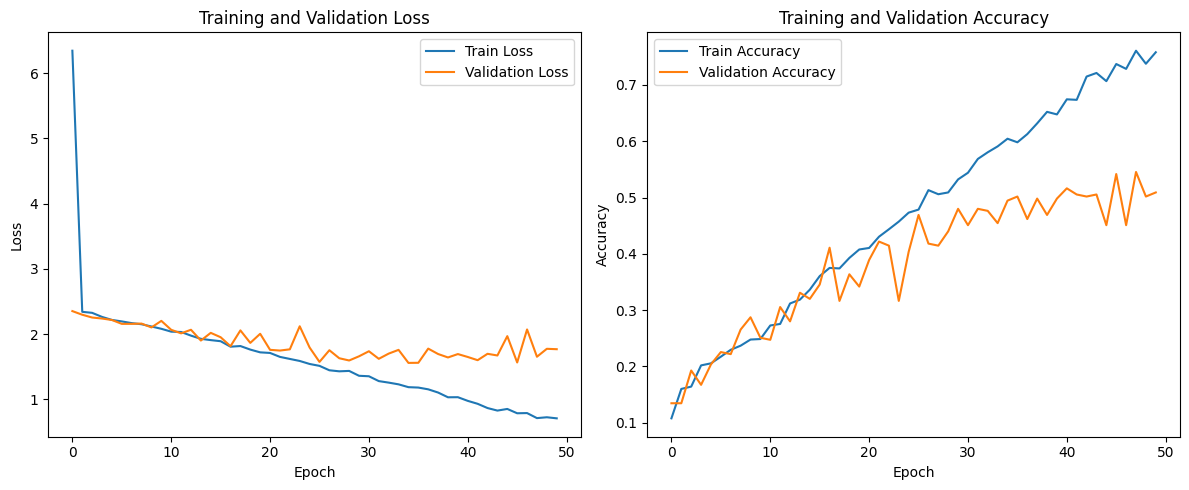

Training complete! Best validation accuracy: 0.5454545454545454


In [ ]:
lr = 0.001
batch_size = 32

model = StandardCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

std_0001_32 = train_model(model, train_loader_32, val_loader_32, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


Train Loss: 4.3096, Train Acc: 0.1327
Validation Loss: 2.3355, Validation Acc: 0.1636
Epoch 2/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.26it/s]


Train Loss: 2.2933, Train Acc: 0.1791
Validation Loss: 2.2746, Validation Acc: 0.2036
Epoch 3/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


Train Loss: 2.2005, Train Acc: 0.2150
Validation Loss: 2.1991, Validation Acc: 0.2145
Epoch 4/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s]


Train Loss: 2.1287, Train Acc: 0.2673
Validation Loss: 2.1459, Validation Acc: 0.2182
Epoch 5/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


Train Loss: 2.0731, Train Acc: 0.2714
Validation Loss: 2.0888, Validation Acc: 0.2364
Epoch 6/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


Train Loss: 2.0252, Train Acc: 0.2968
Validation Loss: 1.9791, Validation Acc: 0.3018
Epoch 7/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Train Loss: 1.9950, Train Acc: 0.3164
Validation Loss: 2.1691, Validation Acc: 0.2509
Epoch 8/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Train Loss: 1.9149, Train Acc: 0.3432
Validation Loss: 1.9709, Validation Acc: 0.3091
Epoch 9/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s]


Train Loss: 1.8528, Train Acc: 0.3709
Validation Loss: 1.8119, Validation Acc: 0.3782
Epoch 10/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s]


Train Loss: 1.7862, Train Acc: 0.4005
Validation Loss: 1.7765, Validation Acc: 0.3855
Epoch 11/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s]


Train Loss: 1.7433, Train Acc: 0.4059
Validation Loss: 1.8746, Validation Acc: 0.3745
Epoch 12/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Train Loss: 1.7415, Train Acc: 0.4168
Validation Loss: 1.7952, Validation Acc: 0.3964
Epoch 13/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


Train Loss: 1.6934, Train Acc: 0.4218
Validation Loss: 1.8076, Validation Acc: 0.3818
Epoch 14/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.56it/s]


Train Loss: 1.6060, Train Acc: 0.4586
Validation Loss: 1.7359, Validation Acc: 0.3782
Epoch 15/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


Train Loss: 1.5655, Train Acc: 0.4764
Validation Loss: 1.8039, Validation Acc: 0.3891
Epoch 16/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.16it/s]


Train Loss: 1.5489, Train Acc: 0.4932
Validation Loss: 1.7551, Validation Acc: 0.4145
Epoch 17/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s]


Train Loss: 1.4864, Train Acc: 0.5077
Validation Loss: 1.6790, Validation Acc: 0.4291
Epoch 18/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s]


Train Loss: 1.4627, Train Acc: 0.5077
Validation Loss: 1.7271, Validation Acc: 0.4218
Epoch 19/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


Train Loss: 1.3831, Train Acc: 0.5359
Validation Loss: 1.7299, Validation Acc: 0.4400
Epoch 20/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s]


Train Loss: 1.3613, Train Acc: 0.5514
Validation Loss: 1.6208, Validation Acc: 0.4655
Epoch 21/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


Train Loss: 1.2766, Train Acc: 0.5645
Validation Loss: 1.5738, Validation Acc: 0.4618
Epoch 22/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.17it/s]


Train Loss: 1.2492, Train Acc: 0.5923
Validation Loss: 1.5764, Validation Acc: 0.4836
Epoch 23/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s]


Train Loss: 1.2179, Train Acc: 0.5895
Validation Loss: 1.6084, Validation Acc: 0.4800
Epoch 24/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]


Train Loss: 1.1407, Train Acc: 0.6195
Validation Loss: 1.6937, Validation Acc: 0.4691
Epoch 25/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


Train Loss: 1.0876, Train Acc: 0.6323
Validation Loss: 1.6477, Validation Acc: 0.4618
Epoch 26/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s]


Train Loss: 1.0640, Train Acc: 0.6459
Validation Loss: 1.7372, Validation Acc: 0.4727
Epoch 27/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s]


Train Loss: 1.0461, Train Acc: 0.6441
Validation Loss: 1.6743, Validation Acc: 0.4800
Epoch 28/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


Train Loss: 0.9664, Train Acc: 0.6714
Validation Loss: 1.5592, Validation Acc: 0.5164
Epoch 29/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.24it/s]


Train Loss: 0.9426, Train Acc: 0.6659
Validation Loss: 1.8448, Validation Acc: 0.4691
Epoch 30/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


Train Loss: 0.9051, Train Acc: 0.6914
Validation Loss: 1.7499, Validation Acc: 0.4982
Epoch 31/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.44it/s]


Train Loss: 0.8593, Train Acc: 0.7141
Validation Loss: 1.5054, Validation Acc: 0.5236
Epoch 32/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.43it/s]


Train Loss: 0.7965, Train Acc: 0.7436
Validation Loss: 1.7803, Validation Acc: 0.4945
Epoch 33/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]


Train Loss: 0.7689, Train Acc: 0.7459
Validation Loss: 1.6693, Validation Acc: 0.5055
Epoch 34/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


Train Loss: 0.7462, Train Acc: 0.7414
Validation Loss: 1.6960, Validation Acc: 0.5200
Epoch 35/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.23it/s]


Train Loss: 0.6788, Train Acc: 0.7791
Validation Loss: 1.7293, Validation Acc: 0.5236
Epoch 36/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


Train Loss: 0.6321, Train Acc: 0.7823
Validation Loss: 1.7455, Validation Acc: 0.5273
Epoch 37/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


Train Loss: 0.5849, Train Acc: 0.8127
Validation Loss: 1.7350, Validation Acc: 0.5309
Epoch 38/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


Train Loss: 0.5966, Train Acc: 0.7982
Validation Loss: 1.8848, Validation Acc: 0.4982
Epoch 39/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


Train Loss: 0.5141, Train Acc: 0.8305
Validation Loss: 1.8582, Validation Acc: 0.4945
Epoch 40/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


Train Loss: 0.4812, Train Acc: 0.8445
Validation Loss: 1.8556, Validation Acc: 0.5164
Epoch 41/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


Train Loss: 0.4946, Train Acc: 0.8323
Validation Loss: 1.8633, Validation Acc: 0.5200
Epoch 42/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.11it/s]


Train Loss: 0.4341, Train Acc: 0.8509
Validation Loss: 1.7983, Validation Acc: 0.5455
Epoch 43/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s]


Train Loss: 0.4204, Train Acc: 0.8568
Validation Loss: 2.0006, Validation Acc: 0.4727
Epoch 44/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


Train Loss: 0.4062, Train Acc: 0.8627
Validation Loss: 1.8340, Validation Acc: 0.5418
Epoch 45/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s]


Train Loss: 0.3858, Train Acc: 0.8741
Validation Loss: 2.0171, Validation Acc: 0.5164
Epoch 46/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


Train Loss: 0.3665, Train Acc: 0.8718
Validation Loss: 1.8511, Validation Acc: 0.5200
Epoch 47/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Train Loss: 0.3364, Train Acc: 0.8873
Validation Loss: 1.9012, Validation Acc: 0.5564
Epoch 48/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


Train Loss: 0.3326, Train Acc: 0.8868
Validation Loss: 1.9040, Validation Acc: 0.5527
Epoch 49/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.43it/s]


Train Loss: 0.3216, Train Acc: 0.8927
Validation Loss: 2.0448, Validation Acc: 0.5236
Epoch 50/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


Train Loss: 0.2895, Train Acc: 0.9023
Validation Loss: 1.8309, Validation Acc: 0.5455


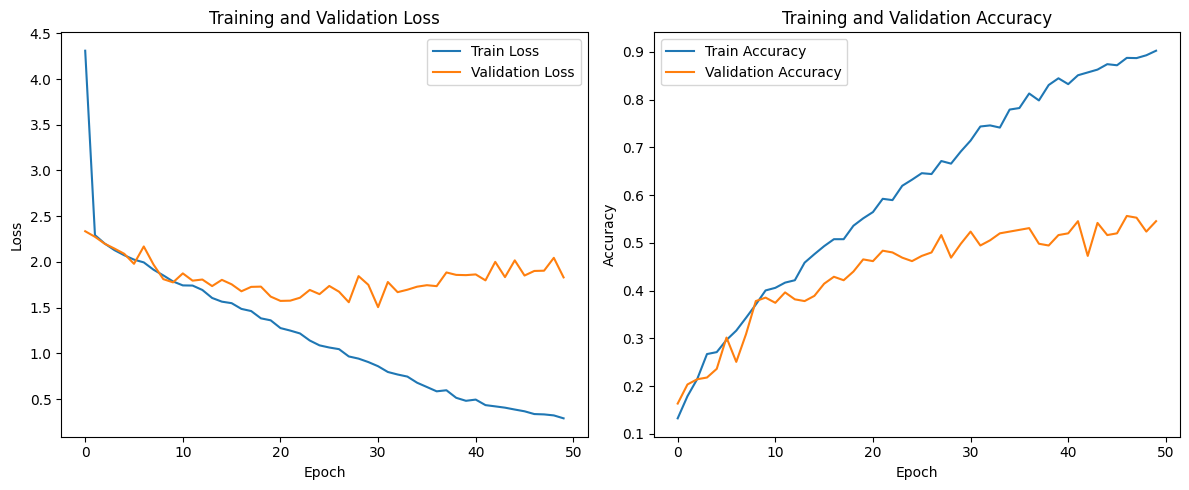

Training complete! Best validation accuracy: 0.5563636363636364


In [ ]:
lr = 0.0005
batch_size = 32

model = StandardCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

std_00005_32 = train_model(model, train_loader_32, val_loader_32, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


Train Loss: 2.4692, Train Acc: 0.1773
Validation Loss: 2.0858, Validation Acc: 0.2545
Epoch 2/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


Train Loss: 2.0112, Train Acc: 0.2882
Validation Loss: 1.8914, Validation Acc: 0.3527
Epoch 3/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


Train Loss: 1.8921, Train Acc: 0.3500
Validation Loss: 1.7770, Validation Acc: 0.3964
Epoch 4/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.30it/s]


Train Loss: 1.8051, Train Acc: 0.3923
Validation Loss: 1.7362, Validation Acc: 0.4255
Epoch 5/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s]


Train Loss: 1.6959, Train Acc: 0.4259
Validation Loss: 1.6619, Validation Acc: 0.4218
Epoch 6/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s]


Train Loss: 1.5837, Train Acc: 0.4741
Validation Loss: 1.6244, Validation Acc: 0.4255
Epoch 7/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


Train Loss: 1.4882, Train Acc: 0.5136
Validation Loss: 1.5977, Validation Acc: 0.4400
Epoch 8/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


Train Loss: 1.4397, Train Acc: 0.5209
Validation Loss: 1.6236, Validation Acc: 0.4800
Epoch 9/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


Train Loss: 1.3184, Train Acc: 0.5614
Validation Loss: 1.4512, Validation Acc: 0.5273
Epoch 10/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


Train Loss: 1.1960, Train Acc: 0.6027
Validation Loss: 1.4665, Validation Acc: 0.5418
Epoch 11/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.08it/s]


Train Loss: 1.1824, Train Acc: 0.6091
Validation Loss: 1.4144, Validation Acc: 0.5127
Epoch 12/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.86it/s]


Train Loss: 1.0725, Train Acc: 0.6432
Validation Loss: 1.4662, Validation Acc: 0.5309
Epoch 13/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


Train Loss: 1.0057, Train Acc: 0.6677
Validation Loss: 1.3713, Validation Acc: 0.4945
Epoch 14/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]


Train Loss: 0.9418, Train Acc: 0.7000
Validation Loss: 1.4091, Validation Acc: 0.5382
Epoch 15/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.71it/s]


Train Loss: 0.8749, Train Acc: 0.7145
Validation Loss: 1.3202, Validation Acc: 0.5709
Epoch 16/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


Train Loss: 0.8013, Train Acc: 0.7505
Validation Loss: 1.4710, Validation Acc: 0.5673
Epoch 17/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s]


Train Loss: 0.7602, Train Acc: 0.7645
Validation Loss: 1.4522, Validation Acc: 0.5636
Epoch 18/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


Train Loss: 0.7275, Train Acc: 0.7623
Validation Loss: 1.3695, Validation Acc: 0.5600
Epoch 19/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


Train Loss: 0.6130, Train Acc: 0.8177
Validation Loss: 1.4703, Validation Acc: 0.5782
Epoch 20/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s]


Train Loss: 0.5973, Train Acc: 0.8182
Validation Loss: 1.3213, Validation Acc: 0.5600
Epoch 21/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Train Loss: 0.5300, Train Acc: 0.8445
Validation Loss: 1.3339, Validation Acc: 0.6000
Epoch 22/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]


Train Loss: 0.4695, Train Acc: 0.8595
Validation Loss: 1.4875, Validation Acc: 0.5491
Epoch 23/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


Train Loss: 0.4456, Train Acc: 0.8673
Validation Loss: 1.3727, Validation Acc: 0.5600
Epoch 24/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


Train Loss: 0.3856, Train Acc: 0.8895
Validation Loss: 1.3701, Validation Acc: 0.5964
Epoch 25/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


Train Loss: 0.3383, Train Acc: 0.9073
Validation Loss: 1.3212, Validation Acc: 0.6000
Epoch 26/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


Train Loss: 0.3492, Train Acc: 0.8991
Validation Loss: 1.4470, Validation Acc: 0.6073
Epoch 27/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


Train Loss: 0.2890, Train Acc: 0.9232
Validation Loss: 1.3048, Validation Acc: 0.5927
Epoch 28/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


Train Loss: 0.2675, Train Acc: 0.9295
Validation Loss: 1.5088, Validation Acc: 0.5891
Epoch 29/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


Train Loss: 0.2586, Train Acc: 0.9332
Validation Loss: 1.3211, Validation Acc: 0.5564
Epoch 30/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 0.2144, Train Acc: 0.9477
Validation Loss: 1.4128, Validation Acc: 0.6400
Epoch 31/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


Train Loss: 0.2040, Train Acc: 0.9486
Validation Loss: 1.3424, Validation Acc: 0.5891
Epoch 32/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


Train Loss: 0.1731, Train Acc: 0.9550
Validation Loss: 1.3780, Validation Acc: 0.5927
Epoch 33/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.26it/s]


Train Loss: 0.1448, Train Acc: 0.9745
Validation Loss: 1.4184, Validation Acc: 0.5964
Epoch 34/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.25it/s]


Train Loss: 0.1459, Train Acc: 0.9705
Validation Loss: 1.5225, Validation Acc: 0.5891
Epoch 35/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


Train Loss: 0.1322, Train Acc: 0.9655
Validation Loss: 1.3988, Validation Acc: 0.6036
Epoch 36/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


Train Loss: 0.1267, Train Acc: 0.9736
Validation Loss: 1.3804, Validation Acc: 0.6218
Epoch 37/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


Train Loss: 0.1186, Train Acc: 0.9705
Validation Loss: 1.3657, Validation Acc: 0.6182
Epoch 38/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


Train Loss: 0.1256, Train Acc: 0.9677
Validation Loss: 1.6336, Validation Acc: 0.5782
Epoch 39/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s]


Train Loss: 0.1019, Train Acc: 0.9786
Validation Loss: 1.5401, Validation Acc: 0.5636
Epoch 40/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s]


Train Loss: 0.1069, Train Acc: 0.9732
Validation Loss: 1.4445, Validation Acc: 0.6109
Epoch 41/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


Train Loss: 0.1053, Train Acc: 0.9750
Validation Loss: 1.4627, Validation Acc: 0.6364
Epoch 42/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


Train Loss: 0.0672, Train Acc: 0.9855
Validation Loss: 1.5220, Validation Acc: 0.5782
Epoch 43/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


Train Loss: 0.0666, Train Acc: 0.9855
Validation Loss: 1.5012, Validation Acc: 0.6109
Epoch 44/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


Train Loss: 0.0512, Train Acc: 0.9945
Validation Loss: 1.3891, Validation Acc: 0.6182
Epoch 45/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s]


Train Loss: 0.0545, Train Acc: 0.9914
Validation Loss: 1.5996, Validation Acc: 0.6327
Epoch 46/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


Train Loss: 0.0514, Train Acc: 0.9914
Validation Loss: 1.3431, Validation Acc: 0.6145
Epoch 47/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.26it/s]


Train Loss: 0.0667, Train Acc: 0.9841
Validation Loss: 1.5864, Validation Acc: 0.6036
Epoch 48/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s]


Train Loss: 0.1027, Train Acc: 0.9755
Validation Loss: 1.8576, Validation Acc: 0.6145
Epoch 49/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


Train Loss: 0.0949, Train Acc: 0.9755
Validation Loss: 1.6326, Validation Acc: 0.6073
Epoch 50/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s]


Train Loss: 0.1001, Train Acc: 0.9668
Validation Loss: 1.7878, Validation Acc: 0.5855


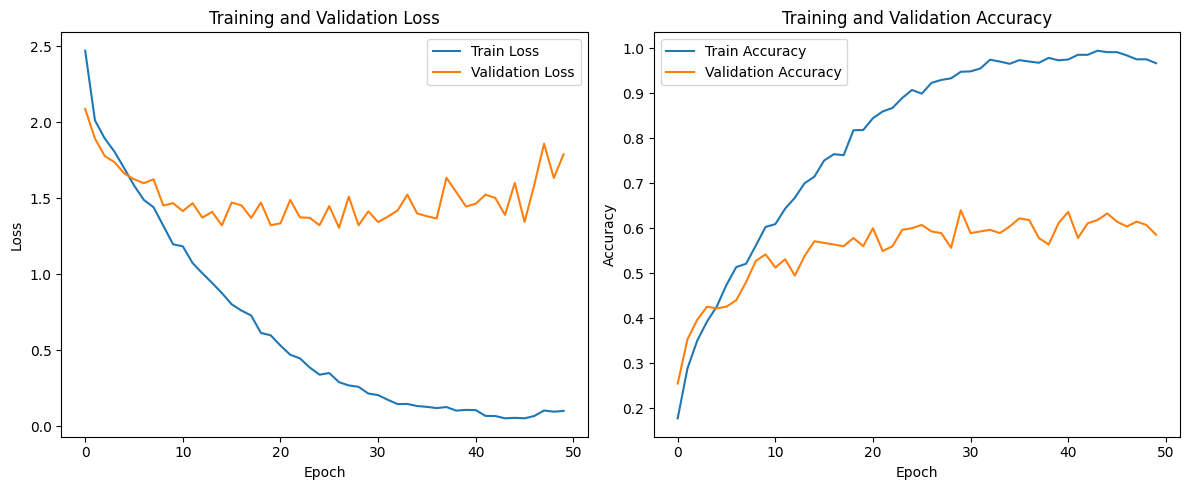

Training complete! Best validation accuracy: 0.64


In [ ]:
lr = 0.0001
batch_size = 32

model = StandardCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

std_00001_32 = train_model(model, train_loader_32, val_loader_32, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


Train Loss: 10.2476, Train Acc: 0.1050
Validation Loss: 2.4625, Validation Acc: 0.1055
Epoch 2/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Train Loss: 2.3846, Train Acc: 0.1191
Validation Loss: 2.3188, Validation Acc: 0.1891
Epoch 3/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Train Loss: 2.3124, Train Acc: 0.1495
Validation Loss: 2.2746, Validation Acc: 0.1673
Epoch 4/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Train Loss: 2.2581, Train Acc: 0.1832
Validation Loss: 2.2646, Validation Acc: 0.1709
Epoch 5/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Train Loss: 2.2179, Train Acc: 0.1973
Validation Loss: 2.2245, Validation Acc: 0.1636
Epoch 6/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


Train Loss: 2.1892, Train Acc: 0.2200
Validation Loss: 2.2489, Validation Acc: 0.1782
Epoch 7/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Train Loss: 2.1545, Train Acc: 0.2418
Validation Loss: 2.1786, Validation Acc: 0.2145
Epoch 8/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Train Loss: 2.1188, Train Acc: 0.2468
Validation Loss: 2.1850, Validation Acc: 0.2436
Epoch 9/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Train Loss: 2.0680, Train Acc: 0.2727
Validation Loss: 2.1461, Validation Acc: 0.2436
Epoch 10/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Train Loss: 2.0272, Train Acc: 0.3000
Validation Loss: 2.0686, Validation Acc: 0.2945
Epoch 11/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Train Loss: 1.9773, Train Acc: 0.3132
Validation Loss: 2.0228, Validation Acc: 0.2727
Epoch 12/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Train Loss: 1.9275, Train Acc: 0.3464
Validation Loss: 2.1352, Validation Acc: 0.2909
Epoch 13/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 1.8784, Train Acc: 0.3700
Validation Loss: 1.9335, Validation Acc: 0.3564
Epoch 14/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Train Loss: 1.8502, Train Acc: 0.3714
Validation Loss: 2.0091, Validation Acc: 0.3127
Epoch 15/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Train Loss: 1.8153, Train Acc: 0.3723
Validation Loss: 1.8623, Validation Acc: 0.3600
Epoch 16/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 1.7502, Train Acc: 0.4018
Validation Loss: 1.8556, Validation Acc: 0.4000
Epoch 17/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Train Loss: 1.7101, Train Acc: 0.4105
Validation Loss: 1.9053, Validation Acc: 0.3818
Epoch 18/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Train Loss: 1.7080, Train Acc: 0.4227
Validation Loss: 1.9560, Validation Acc: 0.3673
Epoch 19/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 1.6483, Train Acc: 0.4468
Validation Loss: 1.7562, Validation Acc: 0.4036
Epoch 20/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Train Loss: 1.6018, Train Acc: 0.4573
Validation Loss: 1.8795, Validation Acc: 0.4036
Epoch 21/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Train Loss: 1.5727, Train Acc: 0.4673
Validation Loss: 1.7706, Validation Acc: 0.4327
Epoch 22/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Train Loss: 1.5554, Train Acc: 0.4755
Validation Loss: 2.2595, Validation Acc: 0.2982
Epoch 23/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


Train Loss: 1.5317, Train Acc: 0.4814
Validation Loss: 1.9329, Validation Acc: 0.3527
Epoch 24/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Train Loss: 1.5254, Train Acc: 0.4823
Validation Loss: 1.8455, Validation Acc: 0.3855
Epoch 25/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Train Loss: 1.5025, Train Acc: 0.4936
Validation Loss: 1.7651, Validation Acc: 0.4145
Epoch 26/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Train Loss: 1.4046, Train Acc: 0.5245
Validation Loss: 1.7100, Validation Acc: 0.4509
Epoch 27/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Train Loss: 1.3907, Train Acc: 0.5350
Validation Loss: 1.9853, Validation Acc: 0.3636
Epoch 28/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Train Loss: 1.3890, Train Acc: 0.5359
Validation Loss: 1.6663, Validation Acc: 0.4400
Epoch 29/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Train Loss: 1.3397, Train Acc: 0.5600
Validation Loss: 1.8075, Validation Acc: 0.3964
Epoch 30/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 1.3311, Train Acc: 0.5509
Validation Loss: 1.8162, Validation Acc: 0.4255
Epoch 31/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Train Loss: 1.2890, Train Acc: 0.5741
Validation Loss: 1.6441, Validation Acc: 0.4909
Epoch 32/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 1.1905, Train Acc: 0.6050
Validation Loss: 1.8465, Validation Acc: 0.4218
Epoch 33/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Train Loss: 1.2292, Train Acc: 0.5936
Validation Loss: 1.9533, Validation Acc: 0.3782
Epoch 34/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


Train Loss: 1.1685, Train Acc: 0.6068
Validation Loss: 1.8612, Validation Acc: 0.4655
Epoch 35/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Train Loss: 1.0881, Train Acc: 0.6332
Validation Loss: 1.6987, Validation Acc: 0.5018
Epoch 36/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Train Loss: 1.0770, Train Acc: 0.6382
Validation Loss: 1.7606, Validation Acc: 0.4364
Epoch 37/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Train Loss: 1.0250, Train Acc: 0.6545
Validation Loss: 1.7453, Validation Acc: 0.4655
Epoch 38/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Train Loss: 0.9961, Train Acc: 0.6659
Validation Loss: 1.6247, Validation Acc: 0.4836
Epoch 39/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Train Loss: 0.9330, Train Acc: 0.6741
Validation Loss: 1.7828, Validation Acc: 0.4655
Epoch 40/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Train Loss: 0.9461, Train Acc: 0.6900
Validation Loss: 1.6900, Validation Acc: 0.4873
Epoch 41/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Train Loss: 0.9562, Train Acc: 0.6750
Validation Loss: 1.9566, Validation Acc: 0.4327
Epoch 42/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Train Loss: 0.8659, Train Acc: 0.7118
Validation Loss: 1.9453, Validation Acc: 0.4582
Epoch 43/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Train Loss: 0.8581, Train Acc: 0.7095
Validation Loss: 1.9092, Validation Acc: 0.4836
Epoch 44/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Train Loss: 0.7859, Train Acc: 0.7323
Validation Loss: 1.7681, Validation Acc: 0.4655
Epoch 45/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Train Loss: 0.7385, Train Acc: 0.7536
Validation Loss: 1.7685, Validation Acc: 0.5091
Epoch 46/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Train Loss: 0.7188, Train Acc: 0.7605
Validation Loss: 1.8850, Validation Acc: 0.4582
Epoch 47/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Train Loss: 0.6890, Train Acc: 0.7559
Validation Loss: 1.9758, Validation Acc: 0.4618
Epoch 48/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Train Loss: 0.6497, Train Acc: 0.7823
Validation Loss: 1.8100, Validation Acc: 0.5200
Epoch 49/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Train Loss: 0.6422, Train Acc: 0.7809
Validation Loss: 1.7254, Validation Acc: 0.5091
Epoch 50/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


Train Loss: 0.6358, Train Acc: 0.7741
Validation Loss: 2.1252, Validation Acc: 0.4800


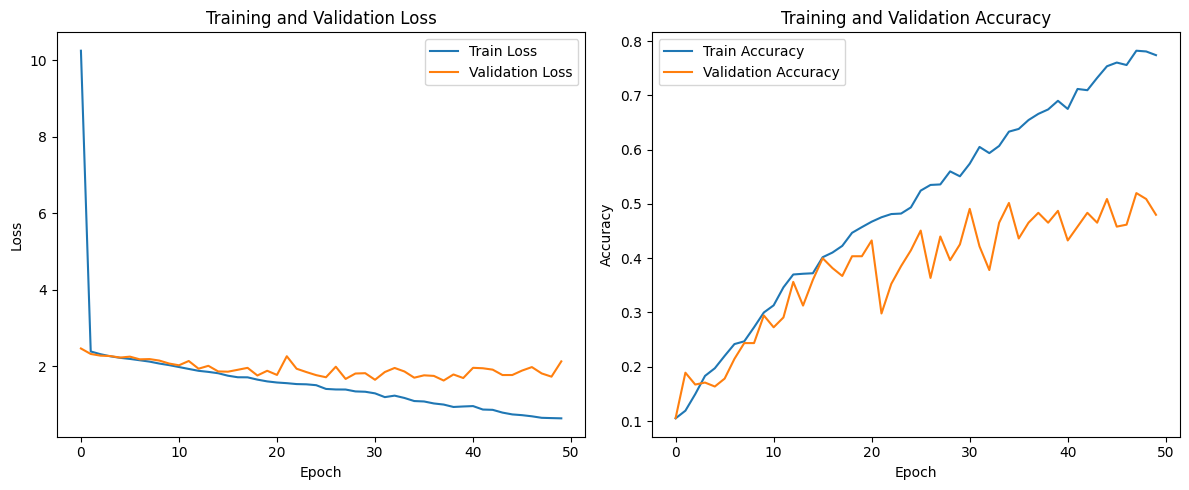

Training complete! Best validation accuracy: 0.52


In [ ]:
lr = 0.001
batch_size = 64

model = StandardCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

std_0001_64 = train_model(model, train_loader_64, val_loader_64, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


Train Loss: 5.5953, Train Acc: 0.0945
Validation Loss: 2.4253, Validation Acc: 0.1455
Epoch 2/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Train Loss: 2.3709, Train Acc: 0.1477
Validation Loss: 2.3097, Validation Acc: 0.1745
Epoch 3/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Train Loss: 2.2498, Train Acc: 0.1918
Validation Loss: 2.2424, Validation Acc: 0.1818
Epoch 4/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Train Loss: 2.2070, Train Acc: 0.2077
Validation Loss: 2.1833, Validation Acc: 0.2073
Epoch 5/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Train Loss: 2.1474, Train Acc: 0.2482
Validation Loss: 2.1792, Validation Acc: 0.2182
Epoch 6/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Train Loss: 2.1029, Train Acc: 0.2682
Validation Loss: 2.1569, Validation Acc: 0.2364
Epoch 7/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Train Loss: 2.0300, Train Acc: 0.3014
Validation Loss: 2.2104, Validation Acc: 0.1891
Epoch 8/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Train Loss: 1.9981, Train Acc: 0.3064
Validation Loss: 2.0630, Validation Acc: 0.2655
Epoch 9/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Train Loss: 1.9259, Train Acc: 0.3436
Validation Loss: 1.9587, Validation Acc: 0.2982
Epoch 10/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Train Loss: 1.8533, Train Acc: 0.3682
Validation Loss: 2.0929, Validation Acc: 0.3091
Epoch 11/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Train Loss: 1.8256, Train Acc: 0.3805
Validation Loss: 1.9135, Validation Acc: 0.3309
Epoch 12/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Train Loss: 1.7363, Train Acc: 0.4077
Validation Loss: 1.8670, Validation Acc: 0.3455
Epoch 13/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Train Loss: 1.7139, Train Acc: 0.4241
Validation Loss: 1.8951, Validation Acc: 0.3891
Epoch 14/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


Train Loss: 1.6305, Train Acc: 0.4473
Validation Loss: 1.8121, Validation Acc: 0.3855
Epoch 15/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Train Loss: 1.6142, Train Acc: 0.4514
Validation Loss: 1.8945, Validation Acc: 0.3418
Epoch 16/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Train Loss: 1.5284, Train Acc: 0.4905
Validation Loss: 1.9113, Validation Acc: 0.3418
Epoch 17/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


Train Loss: 1.4698, Train Acc: 0.5023
Validation Loss: 1.9618, Validation Acc: 0.3782
Epoch 18/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Train Loss: 1.4249, Train Acc: 0.5300
Validation Loss: 1.8829, Validation Acc: 0.4145
Epoch 19/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Train Loss: 1.3613, Train Acc: 0.5400
Validation Loss: 1.7618, Validation Acc: 0.4255
Epoch 20/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Train Loss: 1.2937, Train Acc: 0.5659
Validation Loss: 1.9248, Validation Acc: 0.4036
Epoch 21/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Train Loss: 1.2917, Train Acc: 0.5545
Validation Loss: 1.8571, Validation Acc: 0.4182
Epoch 22/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Train Loss: 1.2390, Train Acc: 0.5795
Validation Loss: 1.8156, Validation Acc: 0.3782
Epoch 23/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Train Loss: 1.1611, Train Acc: 0.6132
Validation Loss: 1.6161, Validation Acc: 0.4364
Epoch 24/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Train Loss: 1.1028, Train Acc: 0.6341
Validation Loss: 1.6984, Validation Acc: 0.4473
Epoch 25/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Train Loss: 1.0571, Train Acc: 0.6441
Validation Loss: 1.7008, Validation Acc: 0.4909
Epoch 26/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Train Loss: 1.0050, Train Acc: 0.6668
Validation Loss: 1.6719, Validation Acc: 0.4582
Epoch 27/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


Train Loss: 0.9702, Train Acc: 0.6686
Validation Loss: 1.8175, Validation Acc: 0.4436
Epoch 28/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Train Loss: 0.9237, Train Acc: 0.6986
Validation Loss: 1.7154, Validation Acc: 0.4909
Epoch 29/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 0.8548, Train Acc: 0.7109
Validation Loss: 1.7368, Validation Acc: 0.4727
Epoch 30/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Train Loss: 0.7614, Train Acc: 0.7491
Validation Loss: 1.7712, Validation Acc: 0.4764
Epoch 31/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Train Loss: 0.7703, Train Acc: 0.7482
Validation Loss: 1.5870, Validation Acc: 0.5055
Epoch 32/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Train Loss: 0.6728, Train Acc: 0.7691
Validation Loss: 1.6778, Validation Acc: 0.4873
Epoch 33/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Train Loss: 0.6416, Train Acc: 0.7918
Validation Loss: 1.8216, Validation Acc: 0.4873
Epoch 34/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Train Loss: 0.5656, Train Acc: 0.8186
Validation Loss: 1.5328, Validation Acc: 0.5418
Epoch 35/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Train Loss: 0.5512, Train Acc: 0.8114
Validation Loss: 1.7300, Validation Acc: 0.5055
Epoch 36/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Train Loss: 0.4885, Train Acc: 0.8459
Validation Loss: 1.7915, Validation Acc: 0.4727
Epoch 37/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Train Loss: 0.4849, Train Acc: 0.8359
Validation Loss: 1.6873, Validation Acc: 0.5236
Epoch 38/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Train Loss: 0.4292, Train Acc: 0.8618
Validation Loss: 1.7978, Validation Acc: 0.5055
Epoch 39/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Train Loss: 0.3938, Train Acc: 0.8755
Validation Loss: 1.8720, Validation Acc: 0.5236
Epoch 40/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


Train Loss: 0.3820, Train Acc: 0.8727
Validation Loss: 1.8834, Validation Acc: 0.4982
Epoch 41/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


Train Loss: 0.3454, Train Acc: 0.8855
Validation Loss: 1.9496, Validation Acc: 0.4764
Epoch 42/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Train Loss: 0.3029, Train Acc: 0.9127
Validation Loss: 1.8886, Validation Acc: 0.4945
Epoch 43/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Train Loss: 0.2989, Train Acc: 0.9027
Validation Loss: 1.8630, Validation Acc: 0.5345
Epoch 44/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Train Loss: 0.2411, Train Acc: 0.9245
Validation Loss: 1.9887, Validation Acc: 0.5127
Epoch 45/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


Train Loss: 0.2411, Train Acc: 0.9264
Validation Loss: 1.9625, Validation Acc: 0.4909
Epoch 46/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Train Loss: 0.2751, Train Acc: 0.9068
Validation Loss: 2.1861, Validation Acc: 0.4836
Epoch 47/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Train Loss: 0.2362, Train Acc: 0.9264
Validation Loss: 2.0576, Validation Acc: 0.5091
Epoch 48/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Train Loss: 0.1936, Train Acc: 0.9391
Validation Loss: 1.9999, Validation Acc: 0.5418
Epoch 49/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


Train Loss: 0.1973, Train Acc: 0.9386
Validation Loss: 2.0542, Validation Acc: 0.4945
Epoch 50/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Train Loss: 0.1684, Train Acc: 0.9527
Validation Loss: 1.9940, Validation Acc: 0.5418


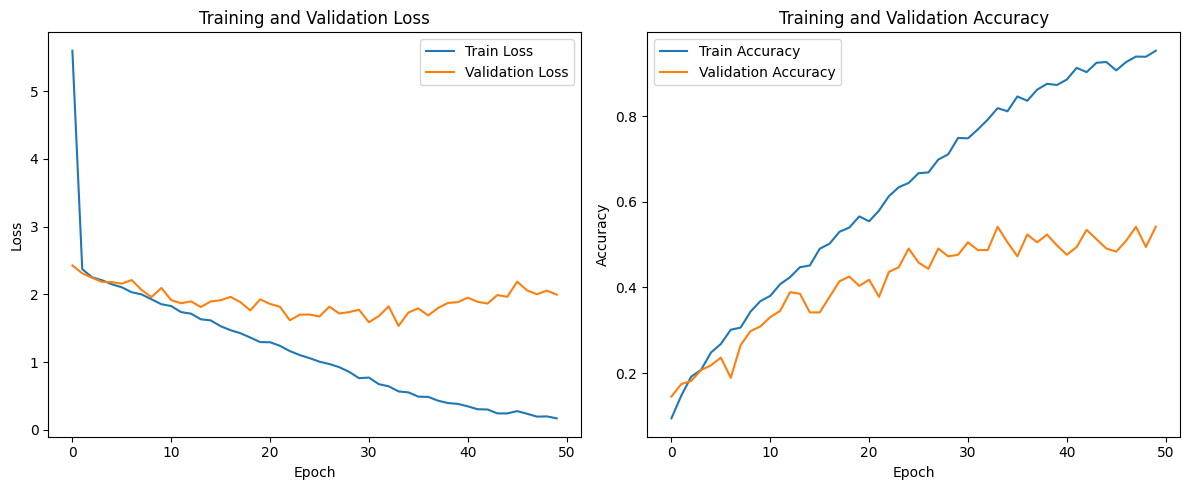

Training complete! Best validation accuracy: 0.5418181818181819


In [ ]:
lr = 0.0005
batch_size = 64

model = StandardCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

std_00005_64 = train_model(model, train_loader_64, val_loader_64, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Train Loss: 2.6045, Train Acc: 0.1695
Validation Loss: 2.3231, Validation Acc: 0.1673
Epoch 2/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Train Loss: 2.0178, Train Acc: 0.3068
Validation Loss: 1.9162, Validation Acc: 0.3745
Epoch 3/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Train Loss: 1.8811, Train Acc: 0.3559
Validation Loss: 1.9070, Validation Acc: 0.3491
Epoch 4/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Train Loss: 1.7779, Train Acc: 0.4068
Validation Loss: 1.7553, Validation Acc: 0.4291
Epoch 5/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Train Loss: 1.7021, Train Acc: 0.4332
Validation Loss: 1.8228, Validation Acc: 0.3709
Epoch 6/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Train Loss: 1.6145, Train Acc: 0.4609
Validation Loss: 1.6481, Validation Acc: 0.4145
Epoch 7/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Train Loss: 1.4978, Train Acc: 0.5073
Validation Loss: 1.7473, Validation Acc: 0.4255
Epoch 8/50


Evaluating...: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Train Loss: 1.4537, Train Acc: 0.5191
Validation Loss: 1.8272, Validation Acc: 0.4255
Epoch 9/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Train Loss: 1.3797, Train Acc: 0.5500
Validation Loss: 1.4824, Validation Acc: 0.4945
Epoch 10/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Train Loss: 1.2849, Train Acc: 0.5791
Validation Loss: 1.5845, Validation Acc: 0.4618
Epoch 11/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 1.1888, Train Acc: 0.6159
Validation Loss: 1.5511, Validation Acc: 0.5018
Epoch 12/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


Train Loss: 1.1084, Train Acc: 0.6405
Validation Loss: 1.5608, Validation Acc: 0.5091
Epoch 13/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Train Loss: 1.0630, Train Acc: 0.6673
Validation Loss: 1.5748, Validation Acc: 0.5236
Epoch 14/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Train Loss: 0.9819, Train Acc: 0.6759
Validation Loss: 1.3675, Validation Acc: 0.5527
Epoch 15/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Train Loss: 0.9236, Train Acc: 0.7055
Validation Loss: 1.4734, Validation Acc: 0.5236
Epoch 16/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Train Loss: 0.8669, Train Acc: 0.7200
Validation Loss: 1.5042, Validation Acc: 0.5600
Epoch 17/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Train Loss: 0.8069, Train Acc: 0.7400
Validation Loss: 1.4318, Validation Acc: 0.5418
Epoch 18/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Train Loss: 0.7804, Train Acc: 0.7600
Validation Loss: 1.6259, Validation Acc: 0.4800
Epoch 19/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Train Loss: 0.7605, Train Acc: 0.7505
Validation Loss: 1.3585, Validation Acc: 0.5455
Epoch 20/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Train Loss: 0.6664, Train Acc: 0.7895
Validation Loss: 1.4133, Validation Acc: 0.5673
Epoch 21/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Train Loss: 0.5702, Train Acc: 0.8345
Validation Loss: 1.4170, Validation Acc: 0.5527
Epoch 22/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Train Loss: 0.5688, Train Acc: 0.8336
Validation Loss: 1.3937, Validation Acc: 0.5600
Epoch 23/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Train Loss: 0.5140, Train Acc: 0.8491
Validation Loss: 1.4390, Validation Acc: 0.5491
Epoch 24/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


Train Loss: 0.4803, Train Acc: 0.8568
Validation Loss: 1.4684, Validation Acc: 0.5782
Epoch 25/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Train Loss: 0.4295, Train Acc: 0.8768
Validation Loss: 1.3999, Validation Acc: 0.5745
Epoch 26/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Train Loss: 0.3745, Train Acc: 0.8973
Validation Loss: 1.3228, Validation Acc: 0.5636
Epoch 27/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Train Loss: 0.3698, Train Acc: 0.8950
Validation Loss: 1.4737, Validation Acc: 0.6145
Epoch 28/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


Train Loss: 0.3293, Train Acc: 0.9182
Validation Loss: 1.4992, Validation Acc: 0.5636
Epoch 29/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Train Loss: 0.2985, Train Acc: 0.9250
Validation Loss: 1.5704, Validation Acc: 0.5418
Epoch 30/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Train Loss: 0.2354, Train Acc: 0.9468
Validation Loss: 1.3071, Validation Acc: 0.5855
Epoch 31/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Train Loss: 0.2051, Train Acc: 0.9555
Validation Loss: 1.2695, Validation Acc: 0.6255
Epoch 32/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 0.2100, Train Acc: 0.9491
Validation Loss: 1.5028, Validation Acc: 0.6109
Epoch 33/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


Train Loss: 0.1861, Train Acc: 0.9591
Validation Loss: 1.3800, Validation Acc: 0.5818
Epoch 34/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


Train Loss: 0.1928, Train Acc: 0.9577
Validation Loss: 1.3832, Validation Acc: 0.6291
Epoch 35/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 0.1803, Train Acc: 0.9595
Validation Loss: 1.4168, Validation Acc: 0.6036
Epoch 36/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Train Loss: 0.1567, Train Acc: 0.9695
Validation Loss: 1.3342, Validation Acc: 0.6036
Epoch 37/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Train Loss: 0.1326, Train Acc: 0.9795
Validation Loss: 1.5180, Validation Acc: 0.6000
Epoch 38/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


Train Loss: 0.1309, Train Acc: 0.9736
Validation Loss: 1.3899, Validation Acc: 0.6291
Epoch 39/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Train Loss: 0.1097, Train Acc: 0.9818
Validation Loss: 1.4405, Validation Acc: 0.5964
Epoch 40/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Train Loss: 0.1297, Train Acc: 0.9673
Validation Loss: 1.7567, Validation Acc: 0.5564
Epoch 41/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Train Loss: 0.0932, Train Acc: 0.9845
Validation Loss: 1.4441, Validation Acc: 0.5818
Epoch 42/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Train Loss: 0.1169, Train Acc: 0.9745
Validation Loss: 1.5259, Validation Acc: 0.6036
Epoch 43/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Train Loss: 0.0932, Train Acc: 0.9845
Validation Loss: 1.5674, Validation Acc: 0.5709
Epoch 44/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Train Loss: 0.0724, Train Acc: 0.9900
Validation Loss: 1.3754, Validation Acc: 0.6509
Epoch 45/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Train Loss: 0.0607, Train Acc: 0.9950
Validation Loss: 1.5029, Validation Acc: 0.6145
Epoch 46/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Train Loss: 0.0490, Train Acc: 0.9945
Validation Loss: 1.4807, Validation Acc: 0.6145
Epoch 47/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Train Loss: 0.0522, Train Acc: 0.9927
Validation Loss: 1.5066, Validation Acc: 0.6182
Epoch 48/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Train Loss: 0.0583, Train Acc: 0.9914
Validation Loss: 1.5290, Validation Acc: 0.5855
Epoch 49/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Train Loss: 0.0577, Train Acc: 0.9914
Validation Loss: 1.4944, Validation Acc: 0.6218
Epoch 50/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Train Loss: 0.0564, Train Acc: 0.9923
Validation Loss: 1.6035, Validation Acc: 0.5600


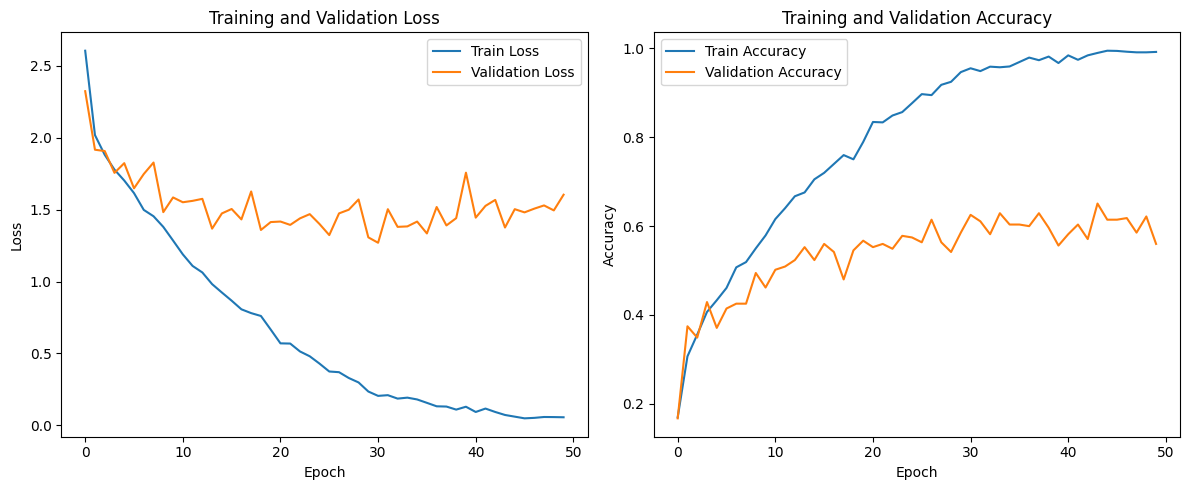

Training complete! Best validation accuracy: 0.6509090909090909


In [ ]:
lr = 0.0001
batch_size = 64

model = StandardCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

std_00001_64 = train_model(model, train_loader_64, val_loader_64, criterion, optimizer, num_epochs=50, device=DEVICE)

In [17]:
best_std_cnn = std_00001_32

Epoch 1/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.57it/s]


Train Loss: 13.9536, Train Acc: 0.1055
Validation Loss: 2.6651, Validation Acc: 0.1055
Epoch 2/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s]


Train Loss: 2.5006, Train Acc: 0.1205
Validation Loss: 2.3856, Validation Acc: 0.2109
Epoch 3/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.43it/s]


Train Loss: 2.3506, Train Acc: 0.1686
Validation Loss: 2.2979, Validation Acc: 0.1709
Epoch 4/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.46it/s]


Train Loss: 2.2330, Train Acc: 0.2091
Validation Loss: 2.2048, Validation Acc: 0.2109
Epoch 5/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.89it/s]


Train Loss: 2.1770, Train Acc: 0.2323
Validation Loss: 2.2089, Validation Acc: 0.2327
Epoch 6/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.70it/s]


Train Loss: 2.0978, Train Acc: 0.2659
Validation Loss: 2.0797, Validation Acc: 0.2727
Epoch 7/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


Train Loss: 2.0467, Train Acc: 0.2900
Validation Loss: 2.0891, Validation Acc: 0.2582
Epoch 8/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.89it/s]


Train Loss: 1.9643, Train Acc: 0.3327
Validation Loss: 1.9849, Validation Acc: 0.3055
Epoch 9/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]


Train Loss: 1.9607, Train Acc: 0.3255
Validation Loss: 1.9530, Validation Acc: 0.3055
Epoch 10/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s]


Train Loss: 1.8988, Train Acc: 0.3482
Validation Loss: 1.9463, Validation Acc: 0.3200
Epoch 11/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


Train Loss: 1.8820, Train Acc: 0.3495
Validation Loss: 2.0583, Validation Acc: 0.2545
Epoch 12/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.90it/s]


Train Loss: 1.8343, Train Acc: 0.3664
Validation Loss: 1.9233, Validation Acc: 0.3273
Epoch 13/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


Train Loss: 1.8014, Train Acc: 0.3836
Validation Loss: 1.9221, Validation Acc: 0.3491
Epoch 14/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]


Train Loss: 1.7763, Train Acc: 0.3909
Validation Loss: 1.9818, Validation Acc: 0.3273
Epoch 15/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.85it/s]


Train Loss: 1.7159, Train Acc: 0.4095
Validation Loss: 1.8839, Validation Acc: 0.3636
Epoch 16/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s]


Train Loss: 1.6872, Train Acc: 0.4141
Validation Loss: 1.8218, Validation Acc: 0.4036
Epoch 17/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


Train Loss: 1.6293, Train Acc: 0.4459
Validation Loss: 1.9935, Validation Acc: 0.3309
Epoch 18/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.82it/s]


Train Loss: 1.6163, Train Acc: 0.4414
Validation Loss: 1.8618, Validation Acc: 0.3745
Epoch 19/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.68it/s]


Train Loss: 1.5895, Train Acc: 0.4686
Validation Loss: 1.9928, Validation Acc: 0.3636
Epoch 20/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


Train Loss: 1.5174, Train Acc: 0.4855
Validation Loss: 1.9664, Validation Acc: 0.3927
Epoch 21/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.68it/s]


Train Loss: 1.5660, Train Acc: 0.4709
Validation Loss: 1.9210, Validation Acc: 0.3782
Epoch 22/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


Train Loss: 1.4872, Train Acc: 0.4932
Validation Loss: 1.8876, Validation Acc: 0.4036
Epoch 23/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]


Train Loss: 1.4461, Train Acc: 0.5091
Validation Loss: 2.0965, Validation Acc: 0.3309
Epoch 24/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


Train Loss: 1.3951, Train Acc: 0.5305
Validation Loss: 1.8815, Validation Acc: 0.3891
Epoch 25/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.54it/s]


Train Loss: 1.3531, Train Acc: 0.5482
Validation Loss: 1.9964, Validation Acc: 0.3818
Epoch 26/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.56it/s]


Train Loss: 1.3139, Train Acc: 0.5532
Validation Loss: 1.9251, Validation Acc: 0.4436
Epoch 27/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.65it/s]


Train Loss: 1.2866, Train Acc: 0.5673
Validation Loss: 2.1012, Validation Acc: 0.3855
Epoch 28/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Train Loss: 1.2268, Train Acc: 0.5845
Validation Loss: 1.9856, Validation Acc: 0.3818
Epoch 29/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


Train Loss: 1.1943, Train Acc: 0.5914
Validation Loss: 1.9604, Validation Acc: 0.3782
Epoch 30/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s]


Train Loss: 1.1511, Train Acc: 0.6100
Validation Loss: 2.1729, Validation Acc: 0.3600
Epoch 31/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.64it/s]


Train Loss: 1.1013, Train Acc: 0.6186
Validation Loss: 2.1477, Validation Acc: 0.4036
Epoch 32/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.62it/s]


Train Loss: 1.1483, Train Acc: 0.6195
Validation Loss: 1.9872, Validation Acc: 0.4364
Epoch 33/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]


Train Loss: 1.0979, Train Acc: 0.6277
Validation Loss: 1.8778, Validation Acc: 0.4364
Epoch 34/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s]


Train Loss: 1.0187, Train Acc: 0.6445
Validation Loss: 2.0509, Validation Acc: 0.4145
Epoch 35/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.83it/s]


Train Loss: 0.9127, Train Acc: 0.6873
Validation Loss: 2.6801, Validation Acc: 0.3818
Epoch 36/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s]


Train Loss: 0.9556, Train Acc: 0.6809
Validation Loss: 2.1563, Validation Acc: 0.4291
Epoch 37/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.50it/s]


Train Loss: 0.8671, Train Acc: 0.6986
Validation Loss: 2.4735, Validation Acc: 0.3745
Epoch 38/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


Train Loss: 0.8253, Train Acc: 0.7209
Validation Loss: 2.5030, Validation Acc: 0.3709
Epoch 39/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


Train Loss: 0.7987, Train Acc: 0.7318
Validation Loss: 2.3366, Validation Acc: 0.4255
Epoch 40/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Train Loss: 0.7853, Train Acc: 0.7300
Validation Loss: 2.4006, Validation Acc: 0.3564
Epoch 41/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]


Train Loss: 0.8445, Train Acc: 0.7236
Validation Loss: 2.1154, Validation Acc: 0.4545
Epoch 42/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s]


Train Loss: 0.6858, Train Acc: 0.7673
Validation Loss: 2.1562, Validation Acc: 0.4727
Epoch 43/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.68it/s]


Train Loss: 0.6395, Train Acc: 0.7736
Validation Loss: 2.5454, Validation Acc: 0.4400
Epoch 44/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.83it/s]


Train Loss: 0.6388, Train Acc: 0.7814
Validation Loss: 2.7149, Validation Acc: 0.4364
Epoch 45/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]


Train Loss: 0.6986, Train Acc: 0.7609
Validation Loss: 2.4126, Validation Acc: 0.4473
Epoch 46/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.79it/s]


Train Loss: 0.6439, Train Acc: 0.7773
Validation Loss: 2.3848, Validation Acc: 0.4218
Epoch 47/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]


Train Loss: 0.5505, Train Acc: 0.8118
Validation Loss: 2.4217, Validation Acc: 0.4436
Epoch 48/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.67it/s]


Train Loss: 0.5215, Train Acc: 0.8214
Validation Loss: 2.4405, Validation Acc: 0.4400
Epoch 49/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.41it/s]


Train Loss: 0.5207, Train Acc: 0.8236
Validation Loss: 2.5768, Validation Acc: 0.4436
Epoch 50/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.03it/s]


Train Loss: 0.5522, Train Acc: 0.8159
Validation Loss: 2.6569, Validation Acc: 0.4255


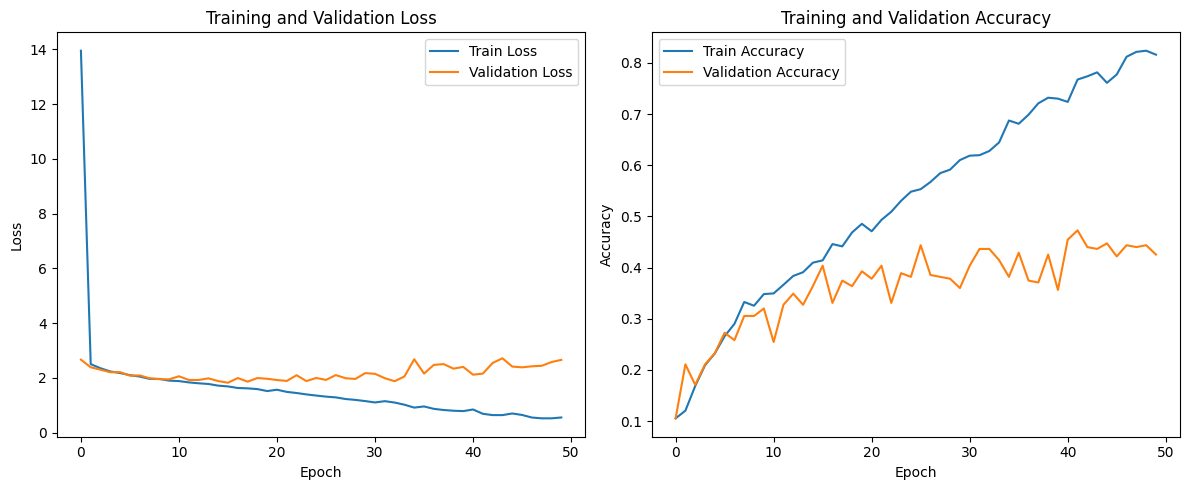

Training complete! Best validation accuracy: 0.4727272727272727


In [ ]:
lr = 0.001
batch_size = 32

model = ResidualCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

res_0001_32 = train_model(model, train_loader_32, val_loader_32, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


Train Loss: 8.0251, Train Acc: 0.1364
Validation Loss: 2.4459, Validation Acc: 0.1455
Epoch 2/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.92it/s]


Train Loss: 2.3668, Train Acc: 0.1827
Validation Loss: 2.4153, Validation Acc: 0.1709
Epoch 3/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


Train Loss: 2.2154, Train Acc: 0.2291
Validation Loss: 2.2973, Validation Acc: 0.1745
Epoch 4/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.16it/s]


Train Loss: 2.1038, Train Acc: 0.2682
Validation Loss: 2.1997, Validation Acc: 0.2145
Epoch 5/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.42it/s]


Train Loss: 2.0096, Train Acc: 0.3068
Validation Loss: 2.0859, Validation Acc: 0.3127
Epoch 6/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


Train Loss: 1.9487, Train Acc: 0.3241
Validation Loss: 2.0692, Validation Acc: 0.2545
Epoch 7/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]


Train Loss: 1.8978, Train Acc: 0.3550
Validation Loss: 1.9981, Validation Acc: 0.3273
Epoch 8/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s]


Train Loss: 1.8504, Train Acc: 0.3791
Validation Loss: 1.9421, Validation Acc: 0.3345
Epoch 9/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]


Train Loss: 1.7429, Train Acc: 0.4036
Validation Loss: 1.9176, Validation Acc: 0.3600
Epoch 10/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.73it/s]


Train Loss: 1.7195, Train Acc: 0.4145
Validation Loss: 1.8773, Validation Acc: 0.3600
Epoch 11/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s]


Train Loss: 1.6960, Train Acc: 0.4236
Validation Loss: 1.8592, Validation Acc: 0.3782
Epoch 12/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s]


Train Loss: 1.6179, Train Acc: 0.4527
Validation Loss: 1.9227, Validation Acc: 0.3345
Epoch 13/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.70it/s]


Train Loss: 1.5546, Train Acc: 0.4805
Validation Loss: 1.8611, Validation Acc: 0.3964
Epoch 14/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.85it/s]


Train Loss: 1.5099, Train Acc: 0.4877
Validation Loss: 1.9661, Validation Acc: 0.3855
Epoch 15/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.23it/s]


Train Loss: 1.4431, Train Acc: 0.5114
Validation Loss: 1.8513, Validation Acc: 0.4073
Epoch 16/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.61it/s]


Train Loss: 1.3985, Train Acc: 0.5373
Validation Loss: 1.8049, Validation Acc: 0.3964
Epoch 17/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.26it/s]


Train Loss: 1.3285, Train Acc: 0.5573
Validation Loss: 1.9318, Validation Acc: 0.4073
Epoch 18/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


Train Loss: 1.2591, Train Acc: 0.5727
Validation Loss: 1.8940, Validation Acc: 0.3964
Epoch 19/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


Train Loss: 1.2020, Train Acc: 0.5886
Validation Loss: 2.0204, Validation Acc: 0.4036
Epoch 20/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.79it/s]


Train Loss: 1.1824, Train Acc: 0.6005
Validation Loss: 1.9542, Validation Acc: 0.3927
Epoch 21/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s]


Train Loss: 1.0998, Train Acc: 0.6241
Validation Loss: 2.0320, Validation Acc: 0.3927
Epoch 22/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.79it/s]


Train Loss: 1.0264, Train Acc: 0.6495
Validation Loss: 1.9805, Validation Acc: 0.4036
Epoch 23/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.78it/s]


Train Loss: 0.9379, Train Acc: 0.6859
Validation Loss: 2.0626, Validation Acc: 0.3818
Epoch 24/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.41it/s]


Train Loss: 0.9259, Train Acc: 0.6895
Validation Loss: 2.0799, Validation Acc: 0.4145
Epoch 25/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


Train Loss: 0.8279, Train Acc: 0.7241
Validation Loss: 2.0389, Validation Acc: 0.4073
Epoch 26/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


Train Loss: 0.7906, Train Acc: 0.7327
Validation Loss: 2.2923, Validation Acc: 0.4473
Epoch 27/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.41it/s]


Train Loss: 0.7334, Train Acc: 0.7482
Validation Loss: 2.4284, Validation Acc: 0.4000
Epoch 28/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.70it/s]


Train Loss: 0.6995, Train Acc: 0.7586
Validation Loss: 2.1661, Validation Acc: 0.4182
Epoch 29/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


Train Loss: 0.6659, Train Acc: 0.7759
Validation Loss: 2.2299, Validation Acc: 0.4000
Epoch 30/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.78it/s]


Train Loss: 0.5668, Train Acc: 0.8159
Validation Loss: 2.4952, Validation Acc: 0.4073
Epoch 31/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


Train Loss: 0.5184, Train Acc: 0.8268
Validation Loss: 2.7381, Validation Acc: 0.3855
Epoch 32/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]


Train Loss: 0.5617, Train Acc: 0.8141
Validation Loss: 2.4176, Validation Acc: 0.4509
Epoch 33/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s]


Train Loss: 0.4645, Train Acc: 0.8400
Validation Loss: 2.8580, Validation Acc: 0.3600
Epoch 34/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.59it/s]


Train Loss: 0.4803, Train Acc: 0.8373
Validation Loss: 2.4164, Validation Acc: 0.4364
Epoch 35/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.24it/s]


Train Loss: 0.4135, Train Acc: 0.8532
Validation Loss: 2.8990, Validation Acc: 0.3891
Epoch 36/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


Train Loss: 0.4074, Train Acc: 0.8650
Validation Loss: 2.8222, Validation Acc: 0.4255
Epoch 37/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s]


Train Loss: 0.3493, Train Acc: 0.8859
Validation Loss: 3.0171, Validation Acc: 0.4073
Epoch 38/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


Train Loss: 0.3706, Train Acc: 0.8686
Validation Loss: 3.0724, Validation Acc: 0.4109
Epoch 39/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.66it/s]


Train Loss: 0.3618, Train Acc: 0.8827
Validation Loss: 2.8826, Validation Acc: 0.4291
Epoch 40/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.92it/s]


Train Loss: 0.3321, Train Acc: 0.8855
Validation Loss: 2.9546, Validation Acc: 0.4218
Epoch 41/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


Train Loss: 0.2699, Train Acc: 0.9145
Validation Loss: 2.7371, Validation Acc: 0.4291
Epoch 42/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.67it/s]


Train Loss: 0.2607, Train Acc: 0.9159
Validation Loss: 2.9174, Validation Acc: 0.3782
Epoch 43/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s]


Train Loss: 0.2616, Train Acc: 0.9091
Validation Loss: 2.8840, Validation Acc: 0.4218
Epoch 44/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.82it/s]


Train Loss: 0.2199, Train Acc: 0.9291
Validation Loss: 3.0766, Validation Acc: 0.4545
Epoch 45/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.65it/s]


Train Loss: 0.1881, Train Acc: 0.9427
Validation Loss: 2.9221, Validation Acc: 0.4327
Epoch 46/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.90it/s]


Train Loss: 0.2374, Train Acc: 0.9177
Validation Loss: 3.6250, Validation Acc: 0.3927
Epoch 47/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.45it/s]


Train Loss: 0.2320, Train Acc: 0.9195
Validation Loss: 3.1723, Validation Acc: 0.3891
Epoch 48/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


Train Loss: 0.1788, Train Acc: 0.9427
Validation Loss: 2.9983, Validation Acc: 0.4036
Epoch 49/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]


Train Loss: 0.1639, Train Acc: 0.9432
Validation Loss: 3.2535, Validation Acc: 0.4109
Epoch 50/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.80it/s]


Train Loss: 0.2391, Train Acc: 0.9241
Validation Loss: 3.5928, Validation Acc: 0.4109


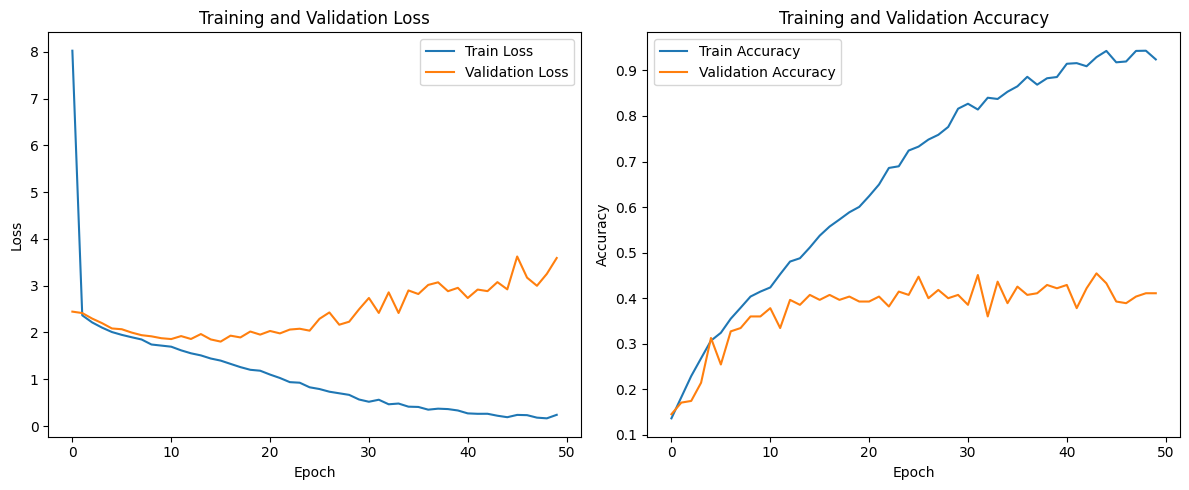

Training complete! Best validation accuracy: 0.45454545454545453


In [ ]:
lr = 0.0005
batch_size = 32

model = ResidualCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

res_00005_32 = train_model(model, train_loader_32, val_loader_32, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.73it/s]


Train Loss: 3.6803, Train Acc: 0.1486
Validation Loss: 2.2403, Validation Acc: 0.2400
Epoch 2/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.81it/s]


Train Loss: 2.1575, Train Acc: 0.2568
Validation Loss: 2.2210, Validation Acc: 0.2655
Epoch 3/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.55it/s]


Train Loss: 2.0404, Train Acc: 0.2977
Validation Loss: 1.9556, Validation Acc: 0.3236
Epoch 4/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


Train Loss: 1.8945, Train Acc: 0.3636
Validation Loss: 1.8674, Validation Acc: 0.3200
Epoch 5/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.69it/s]


Train Loss: 1.7745, Train Acc: 0.3886
Validation Loss: 1.8489, Validation Acc: 0.3782
Epoch 6/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


Train Loss: 1.7199, Train Acc: 0.4223
Validation Loss: 1.7972, Validation Acc: 0.4145
Epoch 7/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s]


Train Loss: 1.6528, Train Acc: 0.4491
Validation Loss: 1.8352, Validation Acc: 0.3818
Epoch 8/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]


Train Loss: 1.5568, Train Acc: 0.4841
Validation Loss: 1.7785, Validation Acc: 0.4545
Epoch 9/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s]


Train Loss: 1.4673, Train Acc: 0.5014
Validation Loss: 1.8583, Validation Acc: 0.3745
Epoch 10/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s]


Train Loss: 1.3861, Train Acc: 0.5291
Validation Loss: 1.7253, Validation Acc: 0.4364
Epoch 11/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 1.2912, Train Acc: 0.5677
Validation Loss: 1.7453, Validation Acc: 0.4291
Epoch 12/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


Train Loss: 1.2194, Train Acc: 0.5982
Validation Loss: 1.7621, Validation Acc: 0.4691
Epoch 13/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.94it/s]


Train Loss: 1.1384, Train Acc: 0.6273
Validation Loss: 1.6413, Validation Acc: 0.4691
Epoch 14/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.61it/s]


Train Loss: 1.0625, Train Acc: 0.6491
Validation Loss: 1.5618, Validation Acc: 0.4909
Epoch 15/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.48it/s]


Train Loss: 0.9827, Train Acc: 0.6741
Validation Loss: 1.7563, Validation Acc: 0.4655
Epoch 16/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.94it/s]


Train Loss: 0.8736, Train Acc: 0.7077
Validation Loss: 1.8492, Validation Acc: 0.4545
Epoch 17/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.55it/s]


Train Loss: 0.8257, Train Acc: 0.7368
Validation Loss: 1.7454, Validation Acc: 0.4655
Epoch 18/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Train Loss: 0.7733, Train Acc: 0.7509
Validation Loss: 1.7570, Validation Acc: 0.4727
Epoch 19/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.64it/s]


Train Loss: 0.6387, Train Acc: 0.8036
Validation Loss: 1.6283, Validation Acc: 0.5127
Epoch 20/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Train Loss: 0.6314, Train Acc: 0.7982
Validation Loss: 1.6124, Validation Acc: 0.5600
Epoch 21/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


Train Loss: 0.5321, Train Acc: 0.8405
Validation Loss: 1.7851, Validation Acc: 0.5018
Epoch 22/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


Train Loss: 0.4885, Train Acc: 0.8523
Validation Loss: 1.6992, Validation Acc: 0.5418
Epoch 23/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.81it/s]


Train Loss: 0.4546, Train Acc: 0.8645
Validation Loss: 1.7131, Validation Acc: 0.5345
Epoch 24/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.89it/s]


Train Loss: 0.3954, Train Acc: 0.8800
Validation Loss: 1.8780, Validation Acc: 0.5236
Epoch 25/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.92it/s]


Train Loss: 0.3846, Train Acc: 0.8773
Validation Loss: 1.7469, Validation Acc: 0.5309
Epoch 26/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.59it/s]


Train Loss: 0.3256, Train Acc: 0.9041
Validation Loss: 1.8769, Validation Acc: 0.4982
Epoch 27/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.27it/s]


Train Loss: 0.2915, Train Acc: 0.9155
Validation Loss: 1.8969, Validation Acc: 0.5273
Epoch 28/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


Train Loss: 0.2720, Train Acc: 0.9250
Validation Loss: 1.9140, Validation Acc: 0.5200
Epoch 29/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s]


Train Loss: 0.2420, Train Acc: 0.9386
Validation Loss: 1.9208, Validation Acc: 0.5055
Epoch 30/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.65it/s]


Train Loss: 0.1918, Train Acc: 0.9536
Validation Loss: 1.9046, Validation Acc: 0.5855
Epoch 31/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.57it/s]


Train Loss: 0.1873, Train Acc: 0.9564
Validation Loss: 1.9369, Validation Acc: 0.5600
Epoch 32/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.78it/s]


Train Loss: 0.1736, Train Acc: 0.9541
Validation Loss: 2.0558, Validation Acc: 0.5055
Epoch 33/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s]


Train Loss: 0.1493, Train Acc: 0.9595
Validation Loss: 1.9196, Validation Acc: 0.5527
Epoch 34/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s]


Train Loss: 0.1600, Train Acc: 0.9559
Validation Loss: 2.0386, Validation Acc: 0.5164
Epoch 35/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.55it/s]


Train Loss: 0.1292, Train Acc: 0.9695
Validation Loss: 2.0465, Validation Acc: 0.5527
Epoch 36/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.73it/s]


Train Loss: 0.1326, Train Acc: 0.9682
Validation Loss: 2.0045, Validation Acc: 0.5345
Epoch 37/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]


Train Loss: 0.1048, Train Acc: 0.9755
Validation Loss: 2.0413, Validation Acc: 0.5309
Epoch 38/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s]


Train Loss: 0.1164, Train Acc: 0.9727
Validation Loss: 2.1627, Validation Acc: 0.5055
Epoch 39/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]


Train Loss: 0.1261, Train Acc: 0.9632
Validation Loss: 2.0748, Validation Acc: 0.4982
Epoch 40/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.61it/s]


Train Loss: 0.1000, Train Acc: 0.9773
Validation Loss: 2.0926, Validation Acc: 0.5455
Epoch 41/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.16it/s]


Train Loss: 0.0714, Train Acc: 0.9855
Validation Loss: 2.1360, Validation Acc: 0.5091
Epoch 42/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


Train Loss: 0.1182, Train Acc: 0.9700
Validation Loss: 2.2629, Validation Acc: 0.4727
Epoch 43/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


Train Loss: 0.1076, Train Acc: 0.9723
Validation Loss: 2.1827, Validation Acc: 0.5091
Epoch 44/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


Train Loss: 0.1207, Train Acc: 0.9673
Validation Loss: 2.3008, Validation Acc: 0.5018
Epoch 45/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


Train Loss: 0.0863, Train Acc: 0.9768
Validation Loss: 2.2332, Validation Acc: 0.5164
Epoch 46/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]


Train Loss: 0.0912, Train Acc: 0.9768
Validation Loss: 2.4708, Validation Acc: 0.5273
Epoch 47/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.51it/s]


Train Loss: 0.0840, Train Acc: 0.9782
Validation Loss: 2.3688, Validation Acc: 0.5564
Epoch 48/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s]


Train Loss: 0.0654, Train Acc: 0.9836
Validation Loss: 2.3556, Validation Acc: 0.5236
Epoch 49/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.41it/s]


Train Loss: 0.0753, Train Acc: 0.9814
Validation Loss: 2.3581, Validation Acc: 0.5673
Epoch 50/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.39it/s]


Train Loss: 0.0911, Train Acc: 0.9727
Validation Loss: 2.4506, Validation Acc: 0.5055


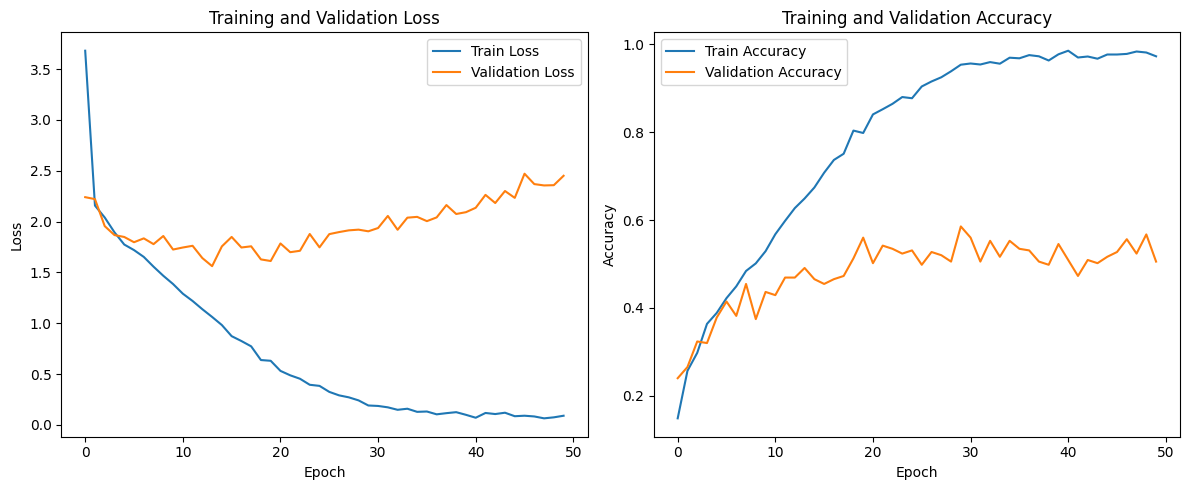

Training complete! Best validation accuracy: 0.5854545454545454


In [ ]:
lr = 0.0001
batch_size = 32

model = ResidualCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

res_00001_32 = train_model(model, train_loader_32, val_loader_32, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


Train Loss: 29.9368, Train Acc: 0.1068
Validation Loss: 3.6011, Validation Acc: 0.0836
Epoch 2/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Train Loss: 2.5863, Train Acc: 0.1164
Validation Loss: 2.5267, Validation Acc: 0.1236
Epoch 3/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


Train Loss: 2.3925, Train Acc: 0.1364
Validation Loss: 2.4330, Validation Acc: 0.1491
Epoch 4/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


Train Loss: 2.3587, Train Acc: 0.1455
Validation Loss: 2.3917, Validation Acc: 0.1273
Epoch 5/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


Train Loss: 2.3004, Train Acc: 0.1650
Validation Loss: 2.3405, Validation Acc: 0.2036
Epoch 6/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


Train Loss: 2.2419, Train Acc: 0.2018
Validation Loss: 2.3306, Validation Acc: 0.1964
Epoch 7/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


Train Loss: 2.2049, Train Acc: 0.2223
Validation Loss: 2.2805, Validation Acc: 0.1782
Epoch 8/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 2.1453, Train Acc: 0.2377
Validation Loss: 2.2255, Validation Acc: 0.2436
Epoch 9/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


Train Loss: 2.0980, Train Acc: 0.2736
Validation Loss: 2.2742, Validation Acc: 0.2291
Epoch 10/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Train Loss: 2.0720, Train Acc: 0.2809
Validation Loss: 2.2247, Validation Acc: 0.2291
Epoch 11/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


Train Loss: 2.0209, Train Acc: 0.2941
Validation Loss: 2.2057, Validation Acc: 0.2145
Epoch 12/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


Train Loss: 1.9669, Train Acc: 0.3264
Validation Loss: 2.1488, Validation Acc: 0.2945
Epoch 13/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Train Loss: 1.9449, Train Acc: 0.3268
Validation Loss: 2.1039, Validation Acc: 0.2982
Epoch 14/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


Train Loss: 1.9141, Train Acc: 0.3341
Validation Loss: 2.2152, Validation Acc: 0.2655
Epoch 15/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Train Loss: 1.8905, Train Acc: 0.3273
Validation Loss: 2.1437, Validation Acc: 0.2655
Epoch 16/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


Train Loss: 1.8497, Train Acc: 0.3605
Validation Loss: 2.0616, Validation Acc: 0.3164
Epoch 17/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


Train Loss: 1.8071, Train Acc: 0.3814
Validation Loss: 2.1475, Validation Acc: 0.2836
Epoch 18/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


Train Loss: 1.7699, Train Acc: 0.3968
Validation Loss: 2.1757, Validation Acc: 0.2873
Epoch 19/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


Train Loss: 1.7350, Train Acc: 0.4055
Validation Loss: 2.0538, Validation Acc: 0.3091
Epoch 20/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


Train Loss: 1.7186, Train Acc: 0.4132
Validation Loss: 2.0631, Validation Acc: 0.3055
Epoch 21/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Train Loss: 1.6850, Train Acc: 0.4318
Validation Loss: 2.0308, Validation Acc: 0.3200
Epoch 22/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Train Loss: 1.6839, Train Acc: 0.4245
Validation Loss: 2.0526, Validation Acc: 0.3055
Epoch 23/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Train Loss: 1.6364, Train Acc: 0.4418
Validation Loss: 2.1874, Validation Acc: 0.2800
Epoch 24/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


Train Loss: 1.5652, Train Acc: 0.4714
Validation Loss: 2.4934, Validation Acc: 0.2909
Epoch 25/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


Train Loss: 1.5917, Train Acc: 0.4641
Validation Loss: 2.3527, Validation Acc: 0.2800
Epoch 26/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Train Loss: 1.5093, Train Acc: 0.4755
Validation Loss: 2.0847, Validation Acc: 0.3455
Epoch 27/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Train Loss: 1.4758, Train Acc: 0.5009
Validation Loss: 2.0835, Validation Acc: 0.3309
Epoch 28/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Train Loss: 1.4469, Train Acc: 0.5105
Validation Loss: 2.1142, Validation Acc: 0.3273
Epoch 29/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


Train Loss: 1.4195, Train Acc: 0.5182
Validation Loss: 2.1419, Validation Acc: 0.3345
Epoch 30/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Train Loss: 1.4026, Train Acc: 0.5259
Validation Loss: 2.2272, Validation Acc: 0.3309
Epoch 31/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


Train Loss: 1.3307, Train Acc: 0.5414
Validation Loss: 2.1603, Validation Acc: 0.3491
Epoch 32/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


Train Loss: 1.2953, Train Acc: 0.5486
Validation Loss: 2.4502, Validation Acc: 0.3455
Epoch 33/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


Train Loss: 1.2350, Train Acc: 0.5773
Validation Loss: 2.2431, Validation Acc: 0.3636
Epoch 34/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 1.1173, Train Acc: 0.6214
Validation Loss: 2.2492, Validation Acc: 0.3564
Epoch 35/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Train Loss: 1.1523, Train Acc: 0.6032
Validation Loss: 2.2959, Validation Acc: 0.3527
Epoch 36/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Train Loss: 1.1448, Train Acc: 0.6082
Validation Loss: 2.4126, Validation Acc: 0.3200
Epoch 37/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


Train Loss: 1.1197, Train Acc: 0.6177
Validation Loss: 2.2566, Validation Acc: 0.3673
Epoch 38/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Train Loss: 1.0510, Train Acc: 0.6482
Validation Loss: 2.2704, Validation Acc: 0.3818
Epoch 39/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Train Loss: 1.0390, Train Acc: 0.6545
Validation Loss: 2.3625, Validation Acc: 0.3309
Epoch 40/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


Train Loss: 0.9763, Train Acc: 0.6695
Validation Loss: 2.4286, Validation Acc: 0.3382
Epoch 41/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Train Loss: 0.9794, Train Acc: 0.6591
Validation Loss: 2.5285, Validation Acc: 0.3491
Epoch 42/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


Train Loss: 0.9536, Train Acc: 0.6818
Validation Loss: 2.4237, Validation Acc: 0.3927
Epoch 43/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 0.9114, Train Acc: 0.6905
Validation Loss: 2.5791, Validation Acc: 0.3455
Epoch 44/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.14it/s]


Train Loss: 0.8507, Train Acc: 0.7064
Validation Loss: 2.6059, Validation Acc: 0.4182
Epoch 45/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 0.8247, Train Acc: 0.7118
Validation Loss: 2.5581, Validation Acc: 0.3600
Epoch 46/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


Train Loss: 0.7826, Train Acc: 0.7327
Validation Loss: 2.7765, Validation Acc: 0.3745
Epoch 47/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


Train Loss: 0.7854, Train Acc: 0.7364
Validation Loss: 2.7222, Validation Acc: 0.3891
Epoch 48/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Train Loss: 0.7614, Train Acc: 0.7414
Validation Loss: 2.4776, Validation Acc: 0.3745
Epoch 49/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


Train Loss: 0.7024, Train Acc: 0.7641
Validation Loss: 2.4323, Validation Acc: 0.3418
Epoch 50/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 0.6685, Train Acc: 0.7814
Validation Loss: 2.7550, Validation Acc: 0.4073


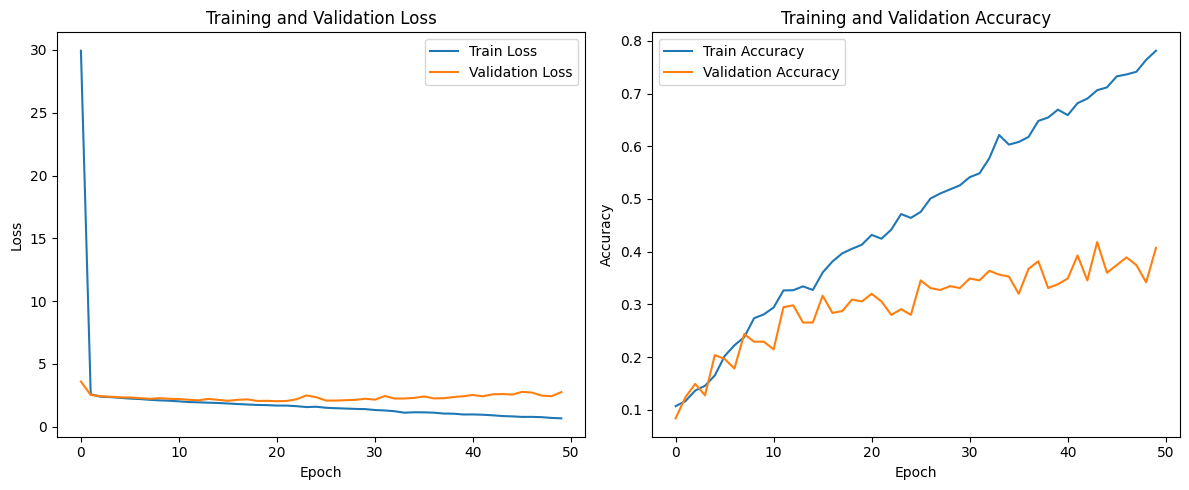

Training complete! Best validation accuracy: 0.41818181818181815


In [ ]:
lr = 0.001
batch_size = 64

model = ResidualCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

res_0001_64 = train_model(model, train_loader_64, val_loader_64, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Train Loss: 15.7706, Train Acc: 0.1000
Validation Loss: 3.3617, Validation Acc: 0.1455
Epoch 2/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Train Loss: 2.5843, Train Acc: 0.1132
Validation Loss: 2.5316, Validation Acc: 0.1309
Epoch 3/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


Train Loss: 2.3656, Train Acc: 0.1473
Validation Loss: 2.3685, Validation Acc: 0.1382
Epoch 4/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Train Loss: 2.2389, Train Acc: 0.1982
Validation Loss: 2.2520, Validation Acc: 0.2182
Epoch 5/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Train Loss: 2.1694, Train Acc: 0.2432
Validation Loss: 2.2516, Validation Acc: 0.2109
Epoch 6/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 2.1083, Train Acc: 0.2477
Validation Loss: 2.1746, Validation Acc: 0.2291
Epoch 7/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


Train Loss: 2.0374, Train Acc: 0.2705
Validation Loss: 2.0574, Validation Acc: 0.2873
Epoch 8/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Train Loss: 1.9806, Train Acc: 0.3091
Validation Loss: 2.2570, Validation Acc: 0.2400
Epoch 9/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Train Loss: 1.9964, Train Acc: 0.2977
Validation Loss: 2.1147, Validation Acc: 0.2836
Epoch 10/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Train Loss: 1.9097, Train Acc: 0.3273
Validation Loss: 2.0657, Validation Acc: 0.3055
Epoch 11/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Train Loss: 1.8790, Train Acc: 0.3668
Validation Loss: 2.1824, Validation Acc: 0.2945
Epoch 12/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


Train Loss: 1.8120, Train Acc: 0.3691
Validation Loss: 2.0248, Validation Acc: 0.3455
Epoch 13/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 1.7750, Train Acc: 0.3923
Validation Loss: 2.0687, Validation Acc: 0.3018
Epoch 14/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Train Loss: 1.7020, Train Acc: 0.4273
Validation Loss: 2.0384, Validation Acc: 0.3564
Epoch 15/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 1.6015, Train Acc: 0.4641
Validation Loss: 1.8830, Validation Acc: 0.3636
Epoch 16/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 1.5733, Train Acc: 0.4782
Validation Loss: 1.9677, Validation Acc: 0.3200
Epoch 17/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


Train Loss: 1.5384, Train Acc: 0.4791
Validation Loss: 2.1736, Validation Acc: 0.2800
Epoch 18/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


Train Loss: 1.5499, Train Acc: 0.4759
Validation Loss: 1.9145, Validation Acc: 0.3636
Epoch 19/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Train Loss: 1.4291, Train Acc: 0.5177
Validation Loss: 1.8307, Validation Acc: 0.3964
Epoch 20/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


Train Loss: 1.4205, Train Acc: 0.5164
Validation Loss: 2.1946, Validation Acc: 0.3382
Epoch 21/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


Train Loss: 1.3459, Train Acc: 0.5527
Validation Loss: 2.0419, Validation Acc: 0.3455
Epoch 22/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Train Loss: 1.2712, Train Acc: 0.5836
Validation Loss: 2.0399, Validation Acc: 0.3673
Epoch 23/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Train Loss: 1.1902, Train Acc: 0.6064
Validation Loss: 1.9969, Validation Acc: 0.4364
Epoch 24/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Train Loss: 1.1748, Train Acc: 0.6068
Validation Loss: 2.1755, Validation Acc: 0.3709
Epoch 25/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 1.1033, Train Acc: 0.6355
Validation Loss: 2.0306, Validation Acc: 0.3782
Epoch 26/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Train Loss: 1.0580, Train Acc: 0.6445
Validation Loss: 2.1587, Validation Acc: 0.3527
Epoch 27/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Train Loss: 0.8892, Train Acc: 0.6959
Validation Loss: 2.1597, Validation Acc: 0.3891
Epoch 30/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Train Loss: 0.8719, Train Acc: 0.7086
Validation Loss: 2.2721, Validation Acc: 0.4000
Epoch 31/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 0.7529, Train Acc: 0.7455
Validation Loss: 2.1519, Validation Acc: 0.3927
Epoch 32/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


Train Loss: 0.7454, Train Acc: 0.7418
Validation Loss: 2.2319, Validation Acc: 0.4073
Epoch 33/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


Train Loss: 0.6630, Train Acc: 0.7886
Validation Loss: 2.1814, Validation Acc: 0.3964
Epoch 34/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Train Loss: 0.6269, Train Acc: 0.7932
Validation Loss: 2.2281, Validation Acc: 0.4182
Epoch 35/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


Train Loss: 0.6019, Train Acc: 0.7977
Validation Loss: 2.2233, Validation Acc: 0.4109
Epoch 36/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


Train Loss: 0.5637, Train Acc: 0.8155
Validation Loss: 2.3413, Validation Acc: 0.3818
Epoch 37/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Train Loss: 0.5219, Train Acc: 0.8273
Validation Loss: 2.3130, Validation Acc: 0.4182
Epoch 38/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Train Loss: 0.4421, Train Acc: 0.8600
Validation Loss: 2.3822, Validation Acc: 0.4000
Epoch 39/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


Train Loss: 0.3829, Train Acc: 0.8868
Validation Loss: 2.3323, Validation Acc: 0.4255
Epoch 40/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Train Loss: 0.4343, Train Acc: 0.8491
Validation Loss: 2.4556, Validation Acc: 0.4218
Epoch 41/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Train Loss: 0.4373, Train Acc: 0.8586
Validation Loss: 2.4987, Validation Acc: 0.3891
Epoch 42/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Train Loss: 0.3854, Train Acc: 0.8632
Validation Loss: 2.6598, Validation Acc: 0.3745
Epoch 43/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


Train Loss: 0.3283, Train Acc: 0.8995
Validation Loss: 2.5291, Validation Acc: 0.3927
Epoch 44/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Train Loss: 0.3055, Train Acc: 0.9023
Validation Loss: 2.8054, Validation Acc: 0.4000
Epoch 45/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Train Loss: 0.3005, Train Acc: 0.8955
Validation Loss: 2.6966, Validation Acc: 0.3636
Epoch 46/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Train Loss: 0.2575, Train Acc: 0.9191
Validation Loss: 3.1600, Validation Acc: 0.3745
Epoch 47/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Train Loss: 0.2482, Train Acc: 0.9241
Validation Loss: 2.9506, Validation Acc: 0.4073
Epoch 48/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Train Loss: 0.2088, Train Acc: 0.9350
Validation Loss: 3.0074, Validation Acc: 0.3927
Epoch 49/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Train Loss: 0.1829, Train Acc: 0.9464
Validation Loss: 2.9823, Validation Acc: 0.3927
Epoch 50/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Train Loss: 0.1796, Train Acc: 0.9423
Validation Loss: 3.2013, Validation Acc: 0.3818


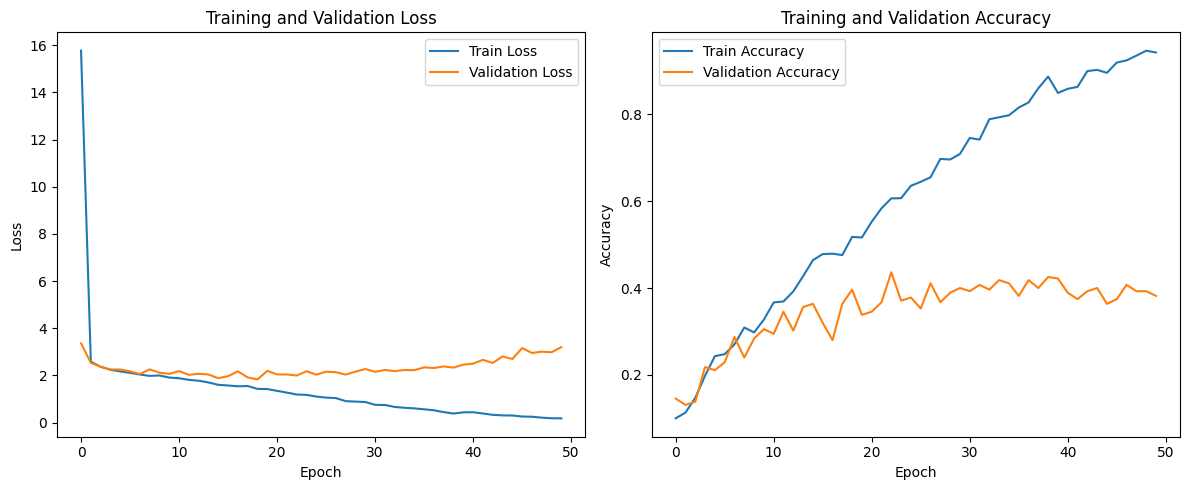

Training complete! Best validation accuracy: 0.43636363636363634


In [ ]:
lr = 0.0005
batch_size = 64

model = ResidualCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

res_00005_64 = train_model(model, train_loader_64, val_loader_64, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


Train Loss: 4.9147, Train Acc: 0.1377
Validation Loss: 2.3306, Validation Acc: 0.1636
Epoch 2/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Train Loss: 2.2471, Train Acc: 0.2086
Validation Loss: 2.1814, Validation Acc: 0.2218
Epoch 3/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Train Loss: 2.1151, Train Acc: 0.2568
Validation Loss: 2.0829, Validation Acc: 0.2655
Epoch 4/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Train Loss: 2.0265, Train Acc: 0.3127
Validation Loss: 1.9939, Validation Acc: 0.3164
Epoch 5/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


Train Loss: 1.9474, Train Acc: 0.3291
Validation Loss: 2.0432, Validation Acc: 0.3055
Epoch 6/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


Train Loss: 1.8688, Train Acc: 0.3741
Validation Loss: 1.9301, Validation Acc: 0.3673
Epoch 7/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Train Loss: 1.8015, Train Acc: 0.3886
Validation Loss: 1.8829, Validation Acc: 0.3891
Epoch 8/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


Train Loss: 1.7417, Train Acc: 0.4168
Validation Loss: 1.8904, Validation Acc: 0.4109
Epoch 9/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


Train Loss: 1.6430, Train Acc: 0.4650
Validation Loss: 1.7710, Validation Acc: 0.4073
Epoch 10/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


Train Loss: 1.5398, Train Acc: 0.4823
Validation Loss: 1.7775, Validation Acc: 0.3818
Epoch 11/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


Train Loss: 1.4754, Train Acc: 0.5127
Validation Loss: 1.9681, Validation Acc: 0.3636
Epoch 12/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Train Loss: 1.4332, Train Acc: 0.5223
Validation Loss: 1.7231, Validation Acc: 0.4545
Epoch 13/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Train Loss: 1.3509, Train Acc: 0.5645
Validation Loss: 1.7523, Validation Acc: 0.4036
Epoch 14/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


Train Loss: 1.3152, Train Acc: 0.5636
Validation Loss: 1.8907, Validation Acc: 0.4327
Epoch 15/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 1.2463, Train Acc: 0.5868
Validation Loss: 1.6929, Validation Acc: 0.4655
Epoch 16/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Train Loss: 1.1174, Train Acc: 0.6355
Validation Loss: 1.6866, Validation Acc: 0.4764
Epoch 17/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


Train Loss: 1.0695, Train Acc: 0.6477
Validation Loss: 1.6055, Validation Acc: 0.5018
Epoch 18/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Train Loss: 1.0122, Train Acc: 0.6636
Validation Loss: 1.6487, Validation Acc: 0.4545
Epoch 19/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


Train Loss: 0.9657, Train Acc: 0.6873
Validation Loss: 1.6556, Validation Acc: 0.4691
Epoch 20/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


Train Loss: 0.9289, Train Acc: 0.6850
Validation Loss: 1.5726, Validation Acc: 0.4764
Epoch 21/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Train Loss: 0.7982, Train Acc: 0.7523
Validation Loss: 1.6871, Validation Acc: 0.4909
Epoch 22/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


Train Loss: 0.7282, Train Acc: 0.7641
Validation Loss: 1.6176, Validation Acc: 0.5164
Epoch 23/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Train Loss: 0.6387, Train Acc: 0.8018
Validation Loss: 1.6353, Validation Acc: 0.5055
Epoch 24/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


Train Loss: 0.6911, Train Acc: 0.7755
Validation Loss: 1.6423, Validation Acc: 0.4764
Epoch 25/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Train Loss: 0.6031, Train Acc: 0.8173
Validation Loss: 1.5487, Validation Acc: 0.5382
Epoch 26/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


Train Loss: 0.5442, Train Acc: 0.8318
Validation Loss: 1.5354, Validation Acc: 0.5309
Epoch 27/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Train Loss: 0.4726, Train Acc: 0.8664
Validation Loss: 1.7223, Validation Acc: 0.4836
Epoch 28/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


Train Loss: 0.4482, Train Acc: 0.8605
Validation Loss: 1.7956, Validation Acc: 0.4800
Epoch 29/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


Train Loss: 0.4254, Train Acc: 0.8755
Validation Loss: 1.7223, Validation Acc: 0.5091
Epoch 30/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


Train Loss: 0.3796, Train Acc: 0.8923
Validation Loss: 1.7026, Validation Acc: 0.5127
Epoch 31/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


Train Loss: 0.3422, Train Acc: 0.9064
Validation Loss: 1.7628, Validation Acc: 0.5200
Epoch 32/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Train Loss: 0.2870, Train Acc: 0.9295
Validation Loss: 1.7246, Validation Acc: 0.5127
Epoch 33/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


Train Loss: 0.2953, Train Acc: 0.9182
Validation Loss: 1.7276, Validation Acc: 0.5309
Epoch 34/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Train Loss: 0.2415, Train Acc: 0.9391
Validation Loss: 1.7766, Validation Acc: 0.5236
Epoch 35/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Train Loss: 0.2469, Train Acc: 0.9364
Validation Loss: 1.9115, Validation Acc: 0.4873
Epoch 36/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Train Loss: 0.1942, Train Acc: 0.9573
Validation Loss: 1.7154, Validation Acc: 0.5273
Epoch 37/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


Train Loss: 0.2017, Train Acc: 0.9550
Validation Loss: 1.8770, Validation Acc: 0.5018
Epoch 38/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Train Loss: 0.1852, Train Acc: 0.9609
Validation Loss: 1.8156, Validation Acc: 0.5018
Epoch 39/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Train Loss: 0.1876, Train Acc: 0.9595
Validation Loss: 1.8811, Validation Acc: 0.5345
Epoch 40/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


Train Loss: 0.1793, Train Acc: 0.9514
Validation Loss: 2.0682, Validation Acc: 0.5018
Epoch 41/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


Train Loss: 0.1404, Train Acc: 0.9705
Validation Loss: 1.9453, Validation Acc: 0.5127
Epoch 42/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Train Loss: 0.1436, Train Acc: 0.9659
Validation Loss: 1.8782, Validation Acc: 0.5382
Epoch 43/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


Train Loss: 0.1177, Train Acc: 0.9800
Validation Loss: 1.9595, Validation Acc: 0.4945
Epoch 44/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Train Loss: 0.0884, Train Acc: 0.9891
Validation Loss: 2.0194, Validation Acc: 0.5236
Epoch 45/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


Train Loss: 0.1097, Train Acc: 0.9777
Validation Loss: 1.8050, Validation Acc: 0.5309
Epoch 46/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


Train Loss: 0.0920, Train Acc: 0.9841
Validation Loss: 1.9213, Validation Acc: 0.5273
Epoch 47/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Train Loss: 0.0826, Train Acc: 0.9877
Validation Loss: 1.9587, Validation Acc: 0.5236
Epoch 48/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Train Loss: 0.0846, Train Acc: 0.9859
Validation Loss: 1.9134, Validation Acc: 0.5236
Epoch 49/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


Train Loss: 0.0996, Train Acc: 0.9777
Validation Loss: 2.0622, Validation Acc: 0.5236
Epoch 50/50


Evaluating...: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


Train Loss: 0.0822, Train Acc: 0.9873
Validation Loss: 2.1099, Validation Acc: 0.5091


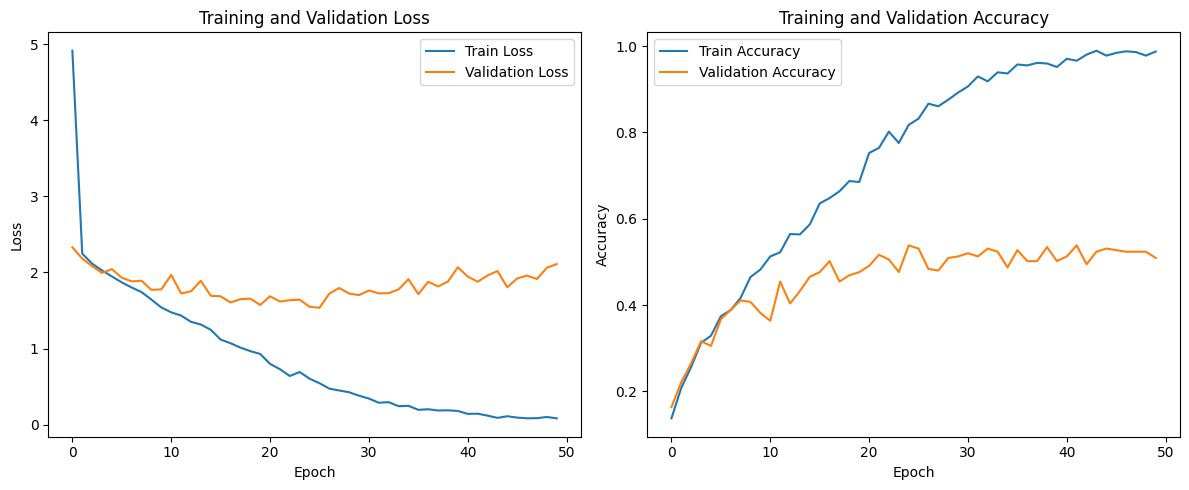

Training complete! Best validation accuracy: 0.5381818181818182


In [ ]:
lr = 0.0001
batch_size = 64

model = ResidualCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

res_00001_64 = train_model(model, train_loader_64, val_loader_64, criterion, optimizer, num_epochs=50, device=DEVICE)

In [ ]:
best_res_cnn = res_00001_64

Evaluating...: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]


Test Loss: 2.3527, Test Acc: 0.5018


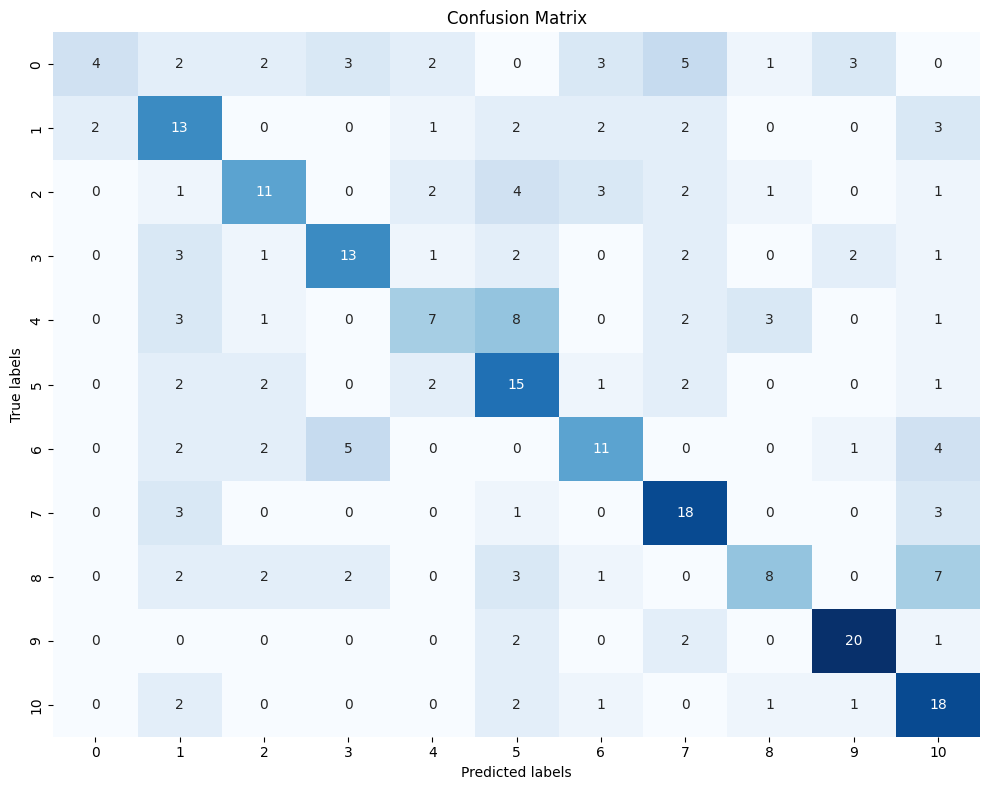

In [25]:
predicted_std, labels_std, cm_std = test_model(best_std_cnn, test_loader_32, criterion, DEVICE)

Evaluating...: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Test Loss: 2.1694, Test Acc: 0.4691


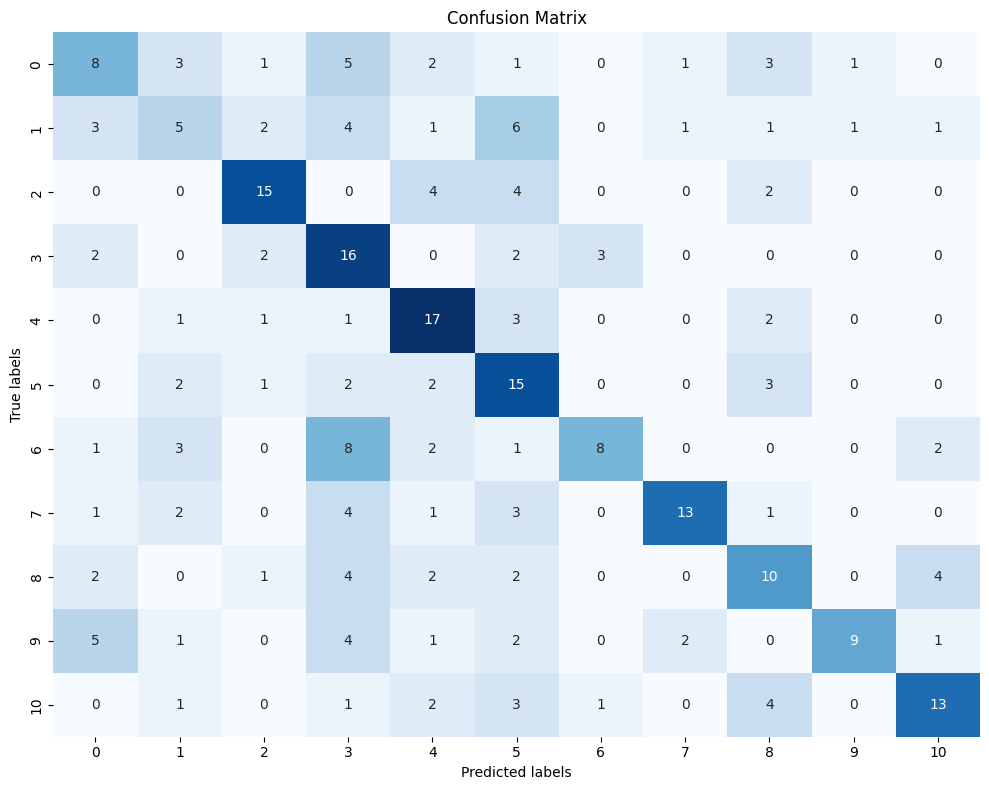

In [15]:
predicted_res, labels_res, cm_std = test_model(best_res_cnn, test_loader_64, criterion, DEVICE)

## Dropout

Epoch 1/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.42it/s]


Train Loss: 2.5240, Train Acc: 0.1632
Validation Loss: 2.1588, Validation Acc: 0.2291
Epoch 2/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]


Train Loss: 2.1386, Train Acc: 0.2582
Validation Loss: 2.0616, Validation Acc: 0.2873
Epoch 3/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


Train Loss: 2.0426, Train Acc: 0.2832
Validation Loss: 1.9697, Validation Acc: 0.2982
Epoch 4/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.35it/s]


Train Loss: 1.9496, Train Acc: 0.3273
Validation Loss: 1.9814, Validation Acc: 0.3018
Epoch 5/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s]


Train Loss: 1.8977, Train Acc: 0.3582
Validation Loss: 1.8232, Validation Acc: 0.3964
Epoch 6/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.26it/s]


Train Loss: 1.8623, Train Acc: 0.3577
Validation Loss: 1.7672, Validation Acc: 0.4109
Epoch 7/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.76it/s]


Train Loss: 1.8138, Train Acc: 0.3836
Validation Loss: 1.6729, Validation Acc: 0.4618
Epoch 8/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 1.7335, Train Acc: 0.4177
Validation Loss: 1.6643, Validation Acc: 0.4691
Epoch 9/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s]


Train Loss: 1.6967, Train Acc: 0.4364
Validation Loss: 1.6184, Validation Acc: 0.4582
Epoch 10/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.17it/s]


Train Loss: 1.5958, Train Acc: 0.4655
Validation Loss: 1.5727, Validation Acc: 0.5018
Epoch 11/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


Train Loss: 1.5506, Train Acc: 0.4714
Validation Loss: 1.5190, Validation Acc: 0.5018
Epoch 12/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


Train Loss: 1.4817, Train Acc: 0.5045
Validation Loss: 1.4516, Validation Acc: 0.4909
Epoch 13/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Train Loss: 1.4256, Train Acc: 0.5268
Validation Loss: 1.4793, Validation Acc: 0.5091
Epoch 14/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


Train Loss: 1.4305, Train Acc: 0.5182
Validation Loss: 1.5590, Validation Acc: 0.4618
Epoch 15/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s]


Train Loss: 1.3565, Train Acc: 0.5555
Validation Loss: 1.5101, Validation Acc: 0.5273
Epoch 16/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


Train Loss: 1.3047, Train Acc: 0.5609
Validation Loss: 1.4324, Validation Acc: 0.5418
Epoch 17/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.34it/s]


Train Loss: 1.2912, Train Acc: 0.5700
Validation Loss: 1.2573, Validation Acc: 0.5782
Epoch 18/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.09it/s]


Train Loss: 1.2087, Train Acc: 0.5909
Validation Loss: 1.4700, Validation Acc: 0.5091
Epoch 19/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


Train Loss: 1.1937, Train Acc: 0.5982
Validation Loss: 1.3277, Validation Acc: 0.5418
Epoch 20/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Train Loss: 1.1574, Train Acc: 0.6173
Validation Loss: 1.3509, Validation Acc: 0.5455
Epoch 21/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s]


Train Loss: 1.1436, Train Acc: 0.6295
Validation Loss: 1.4254, Validation Acc: 0.5600
Epoch 22/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


Train Loss: 1.0919, Train Acc: 0.6318
Validation Loss: 1.3974, Validation Acc: 0.5527
Epoch 23/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.93it/s]


Train Loss: 1.0524, Train Acc: 0.6450
Validation Loss: 1.2309, Validation Acc: 0.5709
Epoch 24/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s]


Train Loss: 1.0258, Train Acc: 0.6623
Validation Loss: 1.2043, Validation Acc: 0.5927
Epoch 25/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]


Train Loss: 0.9690, Train Acc: 0.6914
Validation Loss: 1.2651, Validation Acc: 0.5600
Epoch 26/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]


Train Loss: 0.9554, Train Acc: 0.6755
Validation Loss: 1.3063, Validation Acc: 0.5564
Epoch 27/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.37it/s]


Train Loss: 0.9066, Train Acc: 0.7027
Validation Loss: 1.2957, Validation Acc: 0.5745
Epoch 28/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


Train Loss: 0.8877, Train Acc: 0.7009
Validation Loss: 1.2489, Validation Acc: 0.5600
Epoch 29/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s]


Train Loss: 0.8497, Train Acc: 0.7195
Validation Loss: 1.1902, Validation Acc: 0.6109
Epoch 30/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.14it/s]


Train Loss: 0.8278, Train Acc: 0.7245
Validation Loss: 1.2112, Validation Acc: 0.6073
Epoch 31/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.02it/s]


Train Loss: 0.8260, Train Acc: 0.7241
Validation Loss: 1.3759, Validation Acc: 0.5673
Epoch 32/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.76it/s]


Train Loss: 0.7600, Train Acc: 0.7382
Validation Loss: 1.1319, Validation Acc: 0.6473
Epoch 33/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s]


Train Loss: 0.7644, Train Acc: 0.7486
Validation Loss: 1.1310, Validation Acc: 0.6327
Epoch 34/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s]


Train Loss: 0.7211, Train Acc: 0.7495
Validation Loss: 1.2181, Validation Acc: 0.5782
Epoch 35/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


Train Loss: 0.6743, Train Acc: 0.7723
Validation Loss: 1.2767, Validation Acc: 0.6000
Epoch 36/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


Train Loss: 0.6794, Train Acc: 0.7723
Validation Loss: 1.2580, Validation Acc: 0.5964
Epoch 37/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.48it/s]


Train Loss: 0.6253, Train Acc: 0.7945
Validation Loss: 1.1274, Validation Acc: 0.6327
Epoch 38/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s]


Train Loss: 0.6249, Train Acc: 0.7959
Validation Loss: 1.1348, Validation Acc: 0.6182
Epoch 39/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]


Train Loss: 0.6090, Train Acc: 0.7950
Validation Loss: 1.2288, Validation Acc: 0.6145
Epoch 40/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.30it/s]


Train Loss: 0.5741, Train Acc: 0.8114
Validation Loss: 1.5770, Validation Acc: 0.5782
Epoch 41/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


Train Loss: 0.5530, Train Acc: 0.8218
Validation Loss: 1.2144, Validation Acc: 0.6073
Epoch 42/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


Train Loss: 0.5502, Train Acc: 0.8145
Validation Loss: 1.0630, Validation Acc: 0.6545
Epoch 43/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


Train Loss: 0.5424, Train Acc: 0.8209
Validation Loss: 1.3087, Validation Acc: 0.6109
Epoch 44/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


Train Loss: 0.4853, Train Acc: 0.8391
Validation Loss: 1.1590, Validation Acc: 0.6436
Epoch 45/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s]


Train Loss: 0.5001, Train Acc: 0.8327
Validation Loss: 1.2242, Validation Acc: 0.6618
Epoch 46/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.45it/s]


Train Loss: 0.4867, Train Acc: 0.8359
Validation Loss: 1.2829, Validation Acc: 0.6255
Epoch 47/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


Train Loss: 0.4833, Train Acc: 0.8450
Validation Loss: 1.1469, Validation Acc: 0.6545
Epoch 48/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


Train Loss: 0.4355, Train Acc: 0.8564
Validation Loss: 1.1340, Validation Acc: 0.6582
Epoch 49/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


Train Loss: 0.4275, Train Acc: 0.8605
Validation Loss: 1.1819, Validation Acc: 0.6364
Epoch 50/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


Train Loss: 0.4211, Train Acc: 0.8600
Validation Loss: 1.2753, Validation Acc: 0.6473


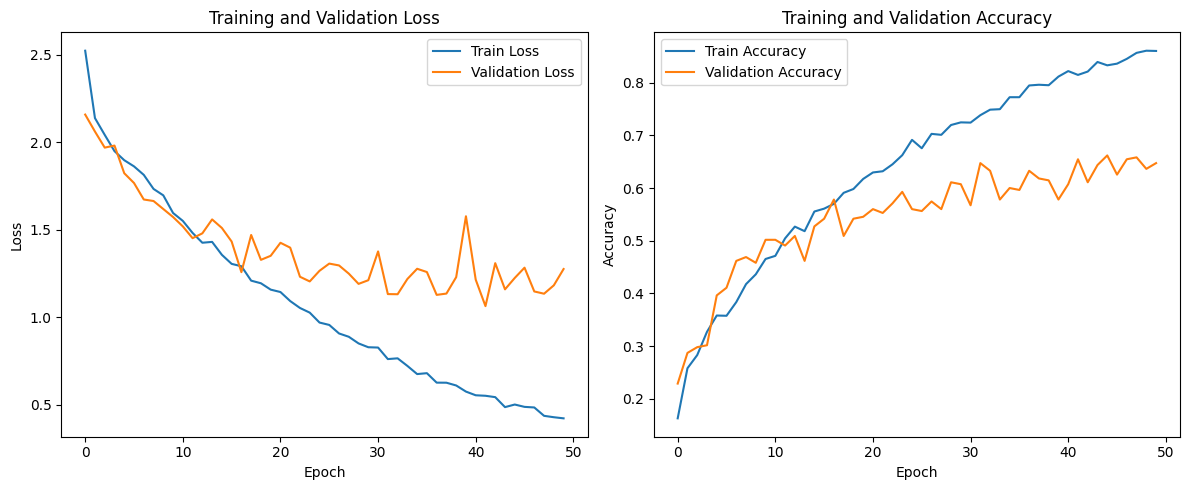

Training complete! Best validation accuracy: 0.6618181818181819


In [ ]:
lr = 0.0001
batch_size = 32

model = StandardCNNwDropout().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

std_dropout_00001_32 = train_model(model, train_loader_32, val_loader_32, criterion, optimizer, num_epochs=50, device=DEVICE)

Epoch 1/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]


Train Loss: 3.3184, Train Acc: 0.1332
Validation Loss: 2.2996, Validation Acc: 0.1964
Epoch 2/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s]


Train Loss: 2.2766, Train Acc: 0.1836
Validation Loss: 2.1751, Validation Acc: 0.2145
Epoch 3/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


Train Loss: 2.1979, Train Acc: 0.2241
Validation Loss: 2.1010, Validation Acc: 0.2691
Epoch 4/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.89it/s]


Train Loss: 2.1397, Train Acc: 0.2559
Validation Loss: 2.0633, Validation Acc: 0.3200
Epoch 5/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.82it/s]


Train Loss: 2.0894, Train Acc: 0.2659
Validation Loss: 2.0275, Validation Acc: 0.2873
Epoch 6/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]


Train Loss: 2.0330, Train Acc: 0.2959
Validation Loss: 1.9244, Validation Acc: 0.3345
Epoch 7/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.44it/s]


Train Loss: 2.0212, Train Acc: 0.2959
Validation Loss: 1.9271, Validation Acc: 0.3818
Epoch 8/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s]


Train Loss: 1.9685, Train Acc: 0.3145
Validation Loss: 1.8017, Validation Acc: 0.3673
Epoch 9/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


Train Loss: 1.9157, Train Acc: 0.3409
Validation Loss: 1.8650, Validation Acc: 0.3345
Epoch 10/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.91it/s]


Train Loss: 1.8896, Train Acc: 0.3550
Validation Loss: 1.8021, Validation Acc: 0.3927
Epoch 11/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]


Train Loss: 1.8888, Train Acc: 0.3568
Validation Loss: 1.7621, Validation Acc: 0.4255
Epoch 12/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]


Train Loss: 1.8304, Train Acc: 0.3736
Validation Loss: 1.6839, Validation Acc: 0.4255
Epoch 13/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]


Train Loss: 1.7959, Train Acc: 0.3982
Validation Loss: 1.7678, Validation Acc: 0.4109
Epoch 14/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]


Train Loss: 1.7660, Train Acc: 0.3941
Validation Loss: 1.6498, Validation Acc: 0.4509
Epoch 15/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.74it/s]


Train Loss: 1.7520, Train Acc: 0.4155
Validation Loss: 1.6138, Validation Acc: 0.4727
Epoch 16/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


Train Loss: 1.6732, Train Acc: 0.4200
Validation Loss: 1.5710, Validation Acc: 0.4800
Epoch 17/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


Train Loss: 1.6728, Train Acc: 0.4336
Validation Loss: 1.5857, Validation Acc: 0.4982
Epoch 18/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.86it/s]


Train Loss: 1.6544, Train Acc: 0.4441
Validation Loss: 1.6234, Validation Acc: 0.4618
Epoch 19/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.37it/s]


Train Loss: 1.5911, Train Acc: 0.4750
Validation Loss: 1.5660, Validation Acc: 0.4255
Epoch 20/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.90it/s]


Train Loss: 1.5732, Train Acc: 0.4645
Validation Loss: 1.5433, Validation Acc: 0.4800
Epoch 21/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


Train Loss: 1.5732, Train Acc: 0.4645
Validation Loss: 1.5937, Validation Acc: 0.4545
Epoch 22/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]


Train Loss: 1.5372, Train Acc: 0.4836
Validation Loss: 1.5741, Validation Acc: 0.4364
Epoch 23/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


Train Loss: 1.5063, Train Acc: 0.5032
Validation Loss: 1.5394, Validation Acc: 0.4727
Epoch 24/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


Train Loss: 1.4590, Train Acc: 0.5036
Validation Loss: 1.4676, Validation Acc: 0.4873
Epoch 25/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s]


Train Loss: 1.4072, Train Acc: 0.5264
Validation Loss: 1.4236, Validation Acc: 0.5527
Epoch 26/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.57it/s]


Train Loss: 1.3980, Train Acc: 0.5200
Validation Loss: 1.4942, Validation Acc: 0.5345
Epoch 27/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.77it/s]


Train Loss: 1.3954, Train Acc: 0.5395
Validation Loss: 1.4248, Validation Acc: 0.5018
Epoch 28/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.49it/s]


Train Loss: 1.3895, Train Acc: 0.5245
Validation Loss: 1.5690, Validation Acc: 0.4945
Epoch 29/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s]


Train Loss: 1.3532, Train Acc: 0.5459
Validation Loss: 1.4368, Validation Acc: 0.5309
Epoch 30/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]


Train Loss: 1.3571, Train Acc: 0.5459
Validation Loss: 1.3894, Validation Acc: 0.5055
Epoch 31/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.59it/s]


Train Loss: 1.3269, Train Acc: 0.5559
Validation Loss: 1.3757, Validation Acc: 0.5418
Epoch 32/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.40it/s]


Train Loss: 1.2641, Train Acc: 0.5750
Validation Loss: 1.3036, Validation Acc: 0.5709
Epoch 33/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.26it/s]


Train Loss: 1.2423, Train Acc: 0.5836
Validation Loss: 1.2732, Validation Acc: 0.5927
Epoch 34/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


Train Loss: 1.2228, Train Acc: 0.5745
Validation Loss: 1.3532, Validation Acc: 0.5309
Epoch 35/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


Train Loss: 1.2096, Train Acc: 0.5836
Validation Loss: 1.2762, Validation Acc: 0.6218
Epoch 36/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.69it/s]


Train Loss: 1.1802, Train Acc: 0.5964
Validation Loss: 1.3211, Validation Acc: 0.5600
Epoch 37/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


Train Loss: 1.1390, Train Acc: 0.6100
Validation Loss: 1.2985, Validation Acc: 0.5382
Epoch 38/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s]


Train Loss: 1.1633, Train Acc: 0.6059
Validation Loss: 1.2922, Validation Acc: 0.5745
Epoch 39/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.83it/s]


Train Loss: 1.1702, Train Acc: 0.6045
Validation Loss: 1.3423, Validation Acc: 0.5564
Epoch 40/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.54it/s]


Train Loss: 1.0958, Train Acc: 0.6245
Validation Loss: 1.3938, Validation Acc: 0.5418
Epoch 41/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s]


Train Loss: 1.0617, Train Acc: 0.6309
Validation Loss: 1.2937, Validation Acc: 0.5855
Epoch 42/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.34it/s]


Train Loss: 1.0730, Train Acc: 0.6282
Validation Loss: 1.2989, Validation Acc: 0.5491
Epoch 43/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.73it/s]


Train Loss: 1.0270, Train Acc: 0.6455
Validation Loss: 1.3241, Validation Acc: 0.5564
Epoch 44/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


Train Loss: 1.0428, Train Acc: 0.6518
Validation Loss: 1.2879, Validation Acc: 0.5818
Epoch 45/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.23it/s]


Train Loss: 0.9998, Train Acc: 0.6586
Validation Loss: 1.3406, Validation Acc: 0.5709
Epoch 46/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


Train Loss: 0.9986, Train Acc: 0.6532
Validation Loss: 1.3325, Validation Acc: 0.5782
Epoch 47/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.02it/s]


Train Loss: 0.9765, Train Acc: 0.6668
Validation Loss: 1.1959, Validation Acc: 0.6036
Epoch 48/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s]


Train Loss: 0.9718, Train Acc: 0.6559
Validation Loss: 1.2301, Validation Acc: 0.6036
Epoch 49/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.82it/s]


Train Loss: 0.9639, Train Acc: 0.6768
Validation Loss: 1.2346, Validation Acc: 0.5964
Epoch 50/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


Train Loss: 0.9041, Train Acc: 0.6832
Validation Loss: 1.3328, Validation Acc: 0.6109


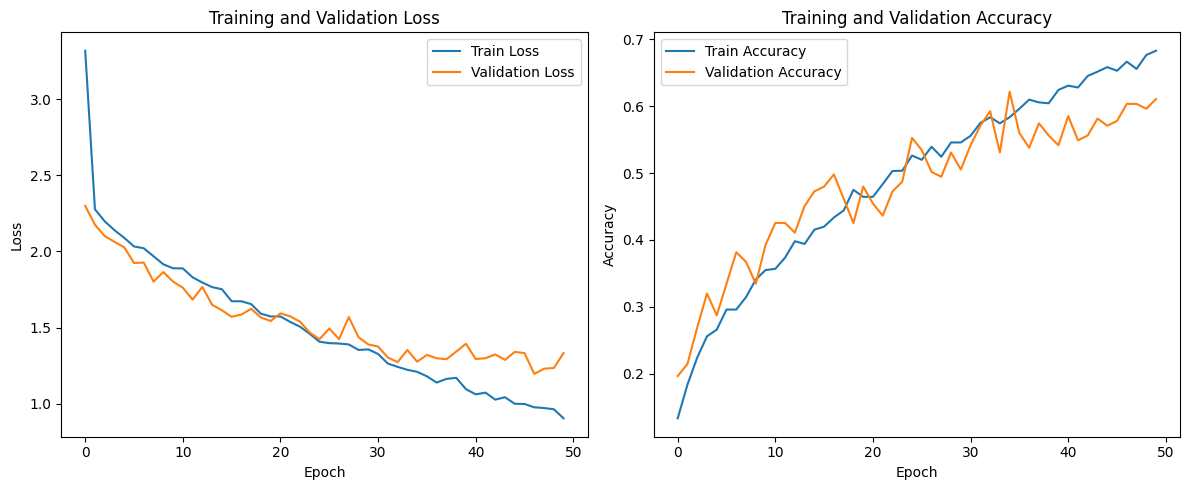

Training complete! Best validation accuracy: 0.6218181818181818


In [ ]:
lr = 0.0001
batch_size = 64

model = ResidualCNNwDropout().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

res_dropout_00001_64 = train_model(model, train_loader_64, val_loader_64, criterion, optimizer, num_epochs=50, device=DEVICE)

In [ ]:
class ShuffleNetTransfer(nn.Module):
    def __init__(self, num_classes=11, freeze_layers=True, unfreeze_conv_layers=0):
        super(ShuffleNetTransfer, self).__init__()
        self.model = models.shufflenet_v2_x1_0(pretrained=True)
        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        
        if freeze_layers:
            for param in self.model.parameters():
                param.requires_grad = False
                
            for param in self.model.fc.parameters():
                param.requires_grad = True
            
            if unfreeze_conv_layers > 0:
                layers_to_unfreeze = ['conv5']
                if unfreeze_conv_layers > 1:
                    layers_to_unfreeze.append('stage4')
                
                for name, param in self.model.named_parameters():
                    for layer in layers_to_unfreeze:
                        if layer in name:
                            param.requires_grad = True
    
    def forward(self, x):
        return self.model(x)

def count_parameters(model):
    params_to_update = []
    names_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            names_to_update.append(name)
    
    print(f"Training {len(params_to_update)}/{len(list(model.parameters()))} parameters")
    print(f"Trainable layers: {names_to_update}")
    return params_to_update

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 68.6MB/s]


Training 2/170 parameters
Trainable layers: ['model.fc.weight', 'model.fc.bias']
Epoch 1/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.20it/s]


Train Loss: 2.3943, Train Acc: 0.1141
Validation Loss: 2.3874, Validation Acc: 0.1891
Epoch 2/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.18it/s]


Train Loss: 2.3853, Train Acc: 0.1832
Validation Loss: 2.3777, Validation Acc: 0.3345
Epoch 3/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s]


Train Loss: 2.3772, Train Acc: 0.2600
Validation Loss: 2.3686, Validation Acc: 0.4436
Epoch 4/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.06it/s]


Train Loss: 2.3690, Train Acc: 0.3514
Validation Loss: 2.3594, Validation Acc: 0.5273
Epoch 5/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.16it/s]


Train Loss: 2.3609, Train Acc: 0.3936
Validation Loss: 2.3495, Validation Acc: 0.5564
Epoch 6/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.25it/s]


Train Loss: 2.3527, Train Acc: 0.4395
Validation Loss: 2.3412, Validation Acc: 0.5964
Epoch 7/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]


Train Loss: 2.3452, Train Acc: 0.4655
Validation Loss: 2.3316, Validation Acc: 0.6145
Epoch 8/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


Train Loss: 2.3376, Train Acc: 0.4823
Validation Loss: 2.3239, Validation Acc: 0.6218
Epoch 9/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.36it/s]


Train Loss: 2.3297, Train Acc: 0.5177
Validation Loss: 2.3154, Validation Acc: 0.6400
Epoch 10/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s]


Train Loss: 2.3209, Train Acc: 0.5282
Validation Loss: 2.3068, Validation Acc: 0.6655
Epoch 11/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.14it/s]


Train Loss: 2.3139, Train Acc: 0.5350
Validation Loss: 2.2966, Validation Acc: 0.7018
Epoch 12/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s]


Train Loss: 2.3073, Train Acc: 0.5486
Validation Loss: 2.2884, Validation Acc: 0.6836
Epoch 13/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.88it/s]


Train Loss: 2.2992, Train Acc: 0.5573
Validation Loss: 2.2799, Validation Acc: 0.7018
Epoch 14/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


Train Loss: 2.2918, Train Acc: 0.5655
Validation Loss: 2.2703, Validation Acc: 0.7091
Epoch 15/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


Train Loss: 2.2839, Train Acc: 0.5791
Validation Loss: 2.2604, Validation Acc: 0.7055
Epoch 16/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s]


Train Loss: 2.2762, Train Acc: 0.5818
Validation Loss: 2.2509, Validation Acc: 0.7200
Epoch 17/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


Train Loss: 2.2697, Train Acc: 0.5923
Validation Loss: 2.2434, Validation Acc: 0.7382
Epoch 18/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.75it/s]


Train Loss: 2.2619, Train Acc: 0.5973
Validation Loss: 2.2344, Validation Acc: 0.7309
Epoch 19/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


Train Loss: 2.2542, Train Acc: 0.6055
Validation Loss: 2.2297, Validation Acc: 0.7527
Epoch 20/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.25it/s]


Train Loss: 2.2471, Train Acc: 0.6295
Validation Loss: 2.2193, Validation Acc: 0.7564
Epoch 21/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s]


Train Loss: 2.2397, Train Acc: 0.6300
Validation Loss: 2.2112, Validation Acc: 0.7455
Epoch 22/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s]


Train Loss: 2.2340, Train Acc: 0.6295
Validation Loss: 2.2065, Validation Acc: 0.7709
Epoch 23/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.47it/s]


Train Loss: 2.2238, Train Acc: 0.6450
Validation Loss: 2.2003, Validation Acc: 0.7636
Epoch 24/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.46it/s]


Train Loss: 2.2178, Train Acc: 0.6518
Validation Loss: 2.1895, Validation Acc: 0.7709
Epoch 25/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.11it/s]


Train Loss: 2.2108, Train Acc: 0.6468
Validation Loss: 2.1771, Validation Acc: 0.7855
Epoch 26/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s]


Train Loss: 2.2045, Train Acc: 0.6491
Validation Loss: 2.1707, Validation Acc: 0.8000
Epoch 27/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]


Train Loss: 2.1979, Train Acc: 0.6355
Validation Loss: 2.1656, Validation Acc: 0.7891
Epoch 28/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.08it/s]


Train Loss: 2.1902, Train Acc: 0.6509
Validation Loss: 2.1559, Validation Acc: 0.7855
Epoch 29/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.45it/s]


Train Loss: 2.1822, Train Acc: 0.6586
Validation Loss: 2.1490, Validation Acc: 0.7891
Epoch 30/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.83it/s]


Train Loss: 2.1764, Train Acc: 0.6586
Validation Loss: 2.1398, Validation Acc: 0.8145
Epoch 31/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.97it/s]


Train Loss: 2.1712, Train Acc: 0.6550
Validation Loss: 2.1318, Validation Acc: 0.7855
Epoch 32/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s]


Train Loss: 2.1599, Train Acc: 0.6650
Validation Loss: 2.1206, Validation Acc: 0.8145
Epoch 33/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s]


Train Loss: 2.1570, Train Acc: 0.6650
Validation Loss: 2.1162, Validation Acc: 0.8036
Epoch 34/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.27it/s]


Train Loss: 2.1478, Train Acc: 0.6682
Validation Loss: 2.1098, Validation Acc: 0.7855
Epoch 35/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.53it/s]


Train Loss: 2.1422, Train Acc: 0.6650
Validation Loss: 2.0989, Validation Acc: 0.8036
Epoch 36/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


Train Loss: 2.1363, Train Acc: 0.6582
Validation Loss: 2.0901, Validation Acc: 0.7927
Epoch 37/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.87it/s]


Train Loss: 2.1300, Train Acc: 0.6582
Validation Loss: 2.0840, Validation Acc: 0.8073
Epoch 38/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.95it/s]


Train Loss: 2.1228, Train Acc: 0.6705
Validation Loss: 2.0796, Validation Acc: 0.8145
Epoch 39/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.10it/s]


Train Loss: 2.1162, Train Acc: 0.6655
Validation Loss: 2.0781, Validation Acc: 0.7891
Epoch 40/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.04it/s]


Train Loss: 2.1114, Train Acc: 0.6691
Validation Loss: 2.0618, Validation Acc: 0.8036
Epoch 41/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]


Train Loss: 2.1010, Train Acc: 0.6782
Validation Loss: 2.0598, Validation Acc: 0.8109
Epoch 42/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.94it/s]


Train Loss: 2.0953, Train Acc: 0.6614
Validation Loss: 2.0485, Validation Acc: 0.8182
Epoch 43/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.83it/s]


Train Loss: 2.0877, Train Acc: 0.6732
Validation Loss: 2.0401, Validation Acc: 0.8036
Epoch 44/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.13it/s]


Train Loss: 2.0841, Train Acc: 0.6664
Validation Loss: 2.0261, Validation Acc: 0.8145
Epoch 45/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


Train Loss: 2.0747, Train Acc: 0.6850
Validation Loss: 2.0267, Validation Acc: 0.8000
Epoch 46/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.70it/s]


Train Loss: 2.0699, Train Acc: 0.6609
Validation Loss: 2.0157, Validation Acc: 0.8218
Epoch 47/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.47it/s]


Train Loss: 2.0689, Train Acc: 0.6673
Validation Loss: 2.0064, Validation Acc: 0.8109
Epoch 48/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.86it/s]


Train Loss: 2.0606, Train Acc: 0.6736
Validation Loss: 2.0013, Validation Acc: 0.8109
Epoch 49/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Train Loss: 2.0513, Train Acc: 0.6791
Validation Loss: 1.9970, Validation Acc: 0.8182
Epoch 50/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.96it/s]


Train Loss: 2.0451, Train Acc: 0.6786
Validation Loss: 1.9925, Validation Acc: 0.7891


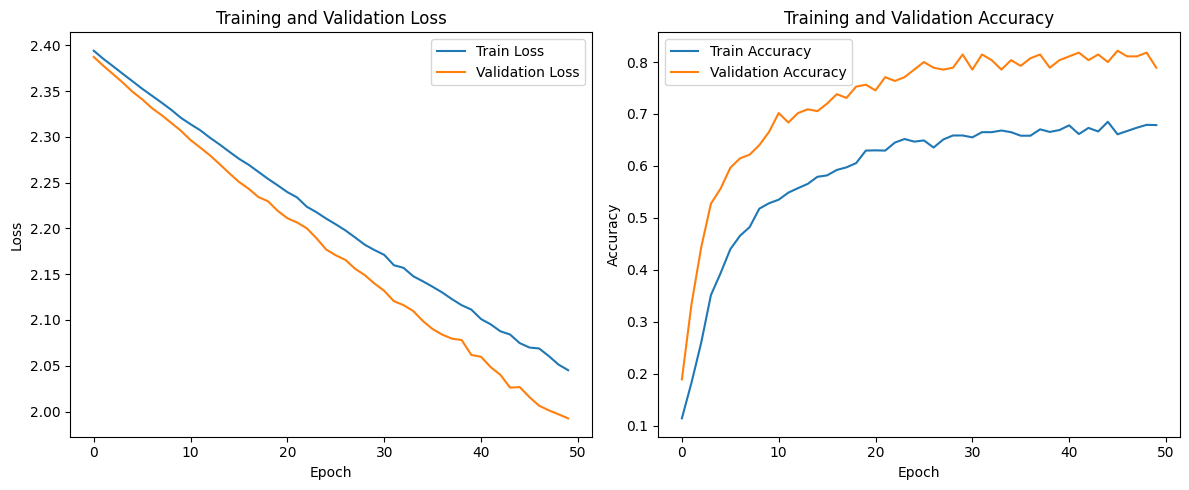

Training complete! Best validation accuracy: 0.8218181818181818


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


Test Loss: 2.0590, Test Acc: 0.6618


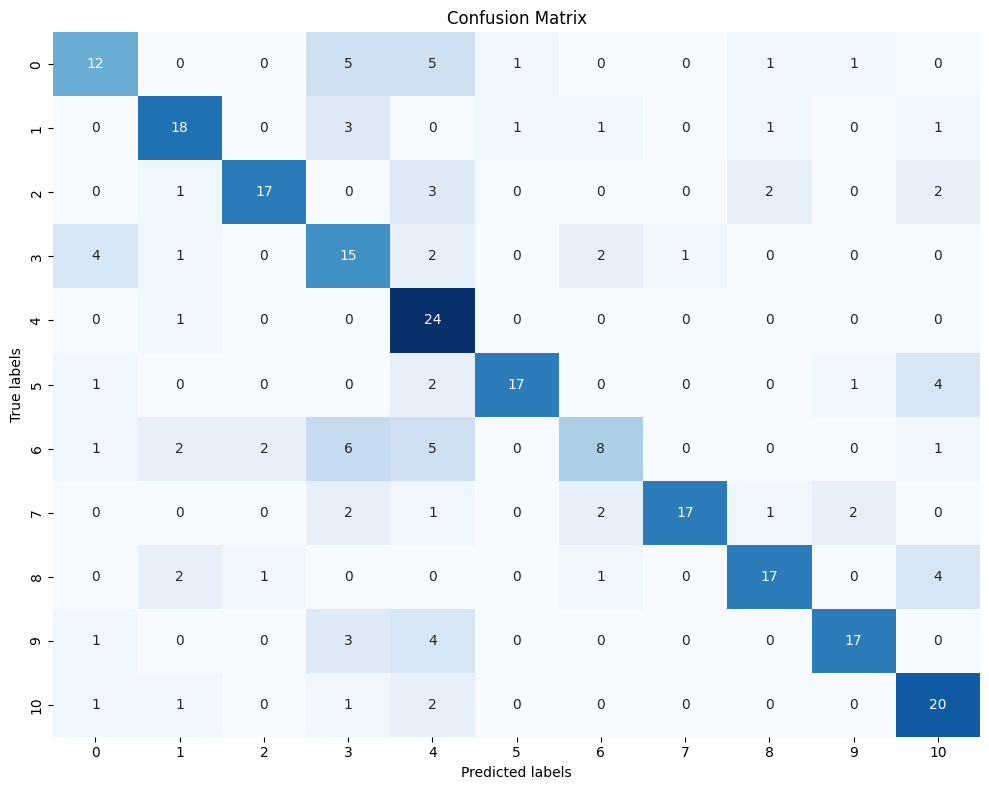

In [ ]:
model_fc_only = ShuffleNetTransfer(num_classes=11, freeze_layers=True, unfreeze_conv_layers=0).to(DEVICE)

trainable_params = count_parameters(model_fc_only)

lr = 0.0001
optimizer = optim.AdamW(trainable_params, lr=lr)
criterion = nn.CrossEntropyLoss()

fc_only_model = train_model(model_fc_only, train_loader_32, val_loader_32, criterion, optimizer, num_epochs=50, device=DEVICE)

fc_only_predicted, fc_only_labels, fc_only_cm = test_model(fc_only_model, test_loader_32, criterion, DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training 47/170 parameters
Trainable layers: ['model.stage4.0.branch1.0.weight', 'model.stage4.0.branch1.1.weight', 'model.stage4.0.branch1.1.bias', 'model.stage4.0.branch1.2.weight', 'model.stage4.0.branch1.3.weight', 'model.stage4.0.branch1.3.bias', 'model.stage4.0.branch2.0.weight', 'model.stage4.0.branch2.1.weight', 'model.stage4.0.branch2.1.bias', 'model.stage4.0.branch2.3.weight', 'model.stage4.0.branch2.4.weight', 'model.stage4.0.branch2.4.bias', 'model.stage4.0.branch2.5.weight', 'model.stage4.0.branch2.6.weight', 'model.stage4.0.branch2.6.bias', 'model.stage4.1.branch2.0.weight', 'model.stage4.1.branch2.1.weight', 'model.stage4.1.branch2.1.bias', 'model.stage4.1.branch2.3.weight', 'model.stage4.1.branch2.4.weight', 'model.stage4.1.branch2.4.bias', 'model.stage4.1.branch2.5.weight', 'model.stage4.1.branch2.6.weight', 'model.stage4.1.branch2.6.bias', 'model.stage4.2.branch2.0.weight', 'model.stage4.2.branch2.1.weight', 'model.stage4.2.branch2.1.bias', 'model.stage4.2.branch2.3.w

Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.20it/s]


Train Loss: 2.3813, Train Acc: 0.2427
Validation Loss: 2.3442, Validation Acc: 0.5273
Epoch 2/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.82it/s]


Train Loss: 2.2944, Train Acc: 0.5359
Validation Loss: 2.1340, Validation Acc: 0.6800
Epoch 3/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.41it/s]


Train Loss: 2.1105, Train Acc: 0.5800
Validation Loss: 1.8833, Validation Acc: 0.7309
Epoch 4/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.09it/s]


Train Loss: 1.8763, Train Acc: 0.5959
Validation Loss: 1.5746, Validation Acc: 0.7309
Epoch 5/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s]


Train Loss: 1.6187, Train Acc: 0.6205
Validation Loss: 1.2793, Validation Acc: 0.7527
Epoch 6/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.60it/s]


Train Loss: 1.3816, Train Acc: 0.6768
Validation Loss: 1.0538, Validation Acc: 0.7855
Epoch 7/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.01it/s]


Train Loss: 1.1938, Train Acc: 0.7055
Validation Loss: 0.9102, Validation Acc: 0.8000
Epoch 8/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.16it/s]


Train Loss: 1.0636, Train Acc: 0.7350
Validation Loss: 0.7712, Validation Acc: 0.8255
Epoch 9/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


Train Loss: 0.9313, Train Acc: 0.7677
Validation Loss: 0.6858, Validation Acc: 0.8473
Epoch 10/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.66it/s]


Train Loss: 0.8172, Train Acc: 0.8005
Validation Loss: 0.6062, Validation Acc: 0.8655
Epoch 11/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Train Loss: 0.7261, Train Acc: 0.8168
Validation Loss: 0.5446, Validation Acc: 0.8618
Epoch 12/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.86it/s]


Train Loss: 0.6585, Train Acc: 0.8300
Validation Loss: 0.4935, Validation Acc: 0.8618
Epoch 13/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.60it/s]


Train Loss: 0.5992, Train Acc: 0.8418
Validation Loss: 0.4591, Validation Acc: 0.8836
Epoch 14/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.86it/s]


Train Loss: 0.5194, Train Acc: 0.8677
Validation Loss: 0.4529, Validation Acc: 0.8655
Epoch 15/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


Train Loss: 0.4969, Train Acc: 0.8655
Validation Loss: 0.4198, Validation Acc: 0.8873
Epoch 16/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.27it/s]


Train Loss: 0.4429, Train Acc: 0.8850
Validation Loss: 0.4134, Validation Acc: 0.8691
Epoch 17/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.67it/s]


Train Loss: 0.3994, Train Acc: 0.8941
Validation Loss: 0.3852, Validation Acc: 0.8836
Epoch 18/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.57it/s]


Train Loss: 0.3796, Train Acc: 0.8977
Validation Loss: 0.3920, Validation Acc: 0.8727
Epoch 19/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]


Train Loss: 0.3390, Train Acc: 0.9114
Validation Loss: 0.3931, Validation Acc: 0.8873
Epoch 20/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


Train Loss: 0.3194, Train Acc: 0.9095
Validation Loss: 0.3670, Validation Acc: 0.8873
Epoch 21/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.50it/s]


Train Loss: 0.2960, Train Acc: 0.9255
Validation Loss: 0.3960, Validation Acc: 0.8800
Epoch 22/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.68it/s]


Train Loss: 0.2736, Train Acc: 0.9323
Validation Loss: 0.3609, Validation Acc: 0.8764
Epoch 23/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.36it/s]


Train Loss: 0.2412, Train Acc: 0.9382
Validation Loss: 0.3893, Validation Acc: 0.8873
Epoch 24/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.81it/s]


Train Loss: 0.2268, Train Acc: 0.9423
Validation Loss: 0.3682, Validation Acc: 0.8945
Epoch 25/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.05it/s]


Train Loss: 0.2181, Train Acc: 0.9423
Validation Loss: 0.3617, Validation Acc: 0.8909
Epoch 26/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


Train Loss: 0.1842, Train Acc: 0.9564
Validation Loss: 0.3531, Validation Acc: 0.8800
Epoch 27/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.32it/s]


Train Loss: 0.1791, Train Acc: 0.9550
Validation Loss: 0.3402, Validation Acc: 0.8909
Epoch 28/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.07it/s]


Train Loss: 0.1732, Train Acc: 0.9568
Validation Loss: 0.3344, Validation Acc: 0.8982
Epoch 29/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]


Train Loss: 0.1620, Train Acc: 0.9650
Validation Loss: 0.3454, Validation Acc: 0.8800
Epoch 30/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.80it/s]


Train Loss: 0.1425, Train Acc: 0.9641
Validation Loss: 0.3526, Validation Acc: 0.8945
Epoch 31/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.69it/s]


Train Loss: 0.1515, Train Acc: 0.9632
Validation Loss: 0.3692, Validation Acc: 0.8873
Epoch 32/50


Evaluating...: 100%|██████████| 9/9 [00:04<00:00,  2.09it/s]


Train Loss: 0.1225, Train Acc: 0.9691
Validation Loss: 0.3610, Validation Acc: 0.8727
Epoch 33/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


Train Loss: 0.1214, Train Acc: 0.9745
Validation Loss: 0.3680, Validation Acc: 0.8764
Epoch 34/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]


Train Loss: 0.1058, Train Acc: 0.9777
Validation Loss: 0.3443, Validation Acc: 0.8982
Epoch 35/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.25it/s]


Train Loss: 0.1082, Train Acc: 0.9723
Validation Loss: 0.3340, Validation Acc: 0.8945
Epoch 36/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  4.81it/s]


Train Loss: 0.0839, Train Acc: 0.9827
Validation Loss: 0.3719, Validation Acc: 0.8836
Epoch 37/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.02it/s]


Train Loss: 0.0911, Train Acc: 0.9782
Validation Loss: 0.3223, Validation Acc: 0.9091
Epoch 38/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.86it/s]


Train Loss: 0.0989, Train Acc: 0.9777
Validation Loss: 0.3272, Validation Acc: 0.9018
Epoch 39/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.96it/s]


Train Loss: 0.0795, Train Acc: 0.9827
Validation Loss: 0.3330, Validation Acc: 0.9091
Epoch 40/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.83it/s]


Train Loss: 0.0759, Train Acc: 0.9832
Validation Loss: 0.3347, Validation Acc: 0.9091
Epoch 41/50


Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


Train Loss: 0.0860, Train Acc: 0.9791
Validation Loss: 0.3133, Validation Acc: 0.9091
Epoch 42/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.42it/s]


Train Loss: 0.0779, Train Acc: 0.9805
Validation Loss: 0.3197, Validation Acc: 0.9127
Epoch 43/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.98it/s]


Train Loss: 0.0640, Train Acc: 0.9841
Validation Loss: 0.3409, Validation Acc: 0.9018
Epoch 44/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


Train Loss: 0.0769, Train Acc: 0.9827
Validation Loss: 0.3510, Validation Acc: 0.8909
Epoch 45/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.44it/s]


Train Loss: 0.0571, Train Acc: 0.9895
Validation Loss: 0.3643, Validation Acc: 0.8909
Epoch 46/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


Train Loss: 0.0581, Train Acc: 0.9882
Validation Loss: 0.3506, Validation Acc: 0.8982
Epoch 47/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.23it/s]


Train Loss: 0.0521, Train Acc: 0.9873
Validation Loss: 0.3583, Validation Acc: 0.8873
Epoch 48/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.20it/s]


Train Loss: 0.0581, Train Acc: 0.9850
Validation Loss: 0.3238, Validation Acc: 0.9055
Epoch 49/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.46it/s]


Train Loss: 0.0514, Train Acc: 0.9886
Validation Loss: 0.3357, Validation Acc: 0.8982
Epoch 50/50


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


Train Loss: 0.0615, Train Acc: 0.9823
Validation Loss: 0.3233, Validation Acc: 0.8945


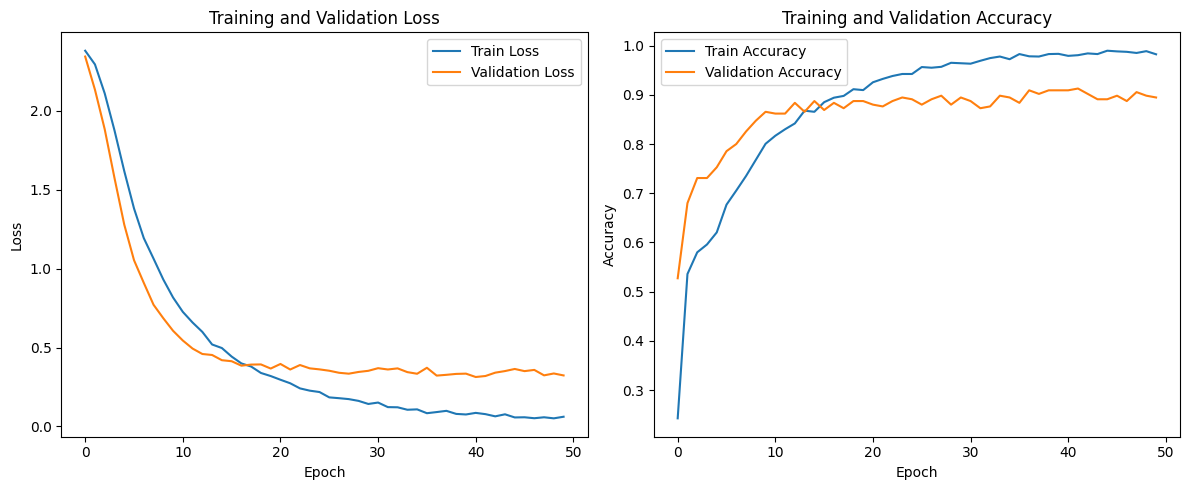

Training complete! Best validation accuracy: 0.9127272727272727


Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


Test Loss: 0.5312, Test Acc: 0.8400


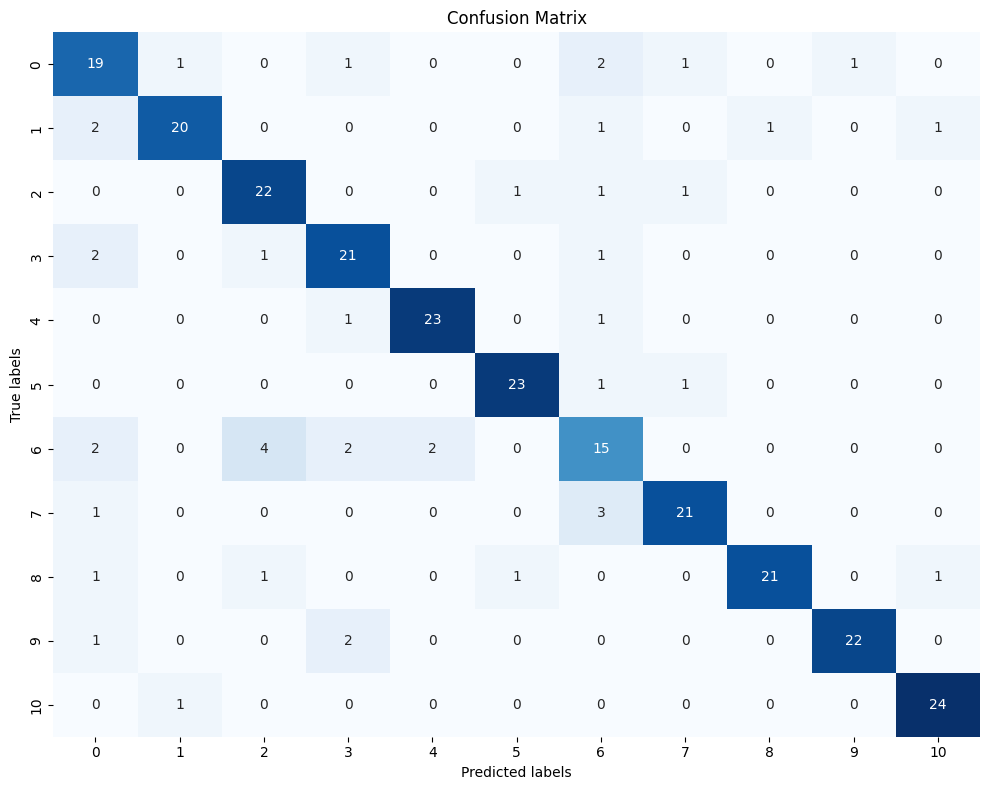

In [ ]:
model_fc_conv = ShuffleNetTransfer(num_classes=11, freeze_layers=True, unfreeze_conv_layers=2).to(DEVICE)

trainable_params = count_parameters(model_fc_conv)

lr = 0.0001
optimizer = optim.AdamW(trainable_params, lr=lr)
criterion = nn.CrossEntropyLoss()

fc_conv_model = train_model(model_fc_conv, train_loader_32, val_loader_32, criterion, optimizer, num_epochs=50, device=DEVICE)

fc_conv_predicted, fc_conv_labels, fc_conv_cm = test_model(fc_conv_model, test_loader_32, criterion, DEVICE)

### Test dropout models

Evaluating...: 100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


Test Loss: 1.8575, Test Acc: 0.4800


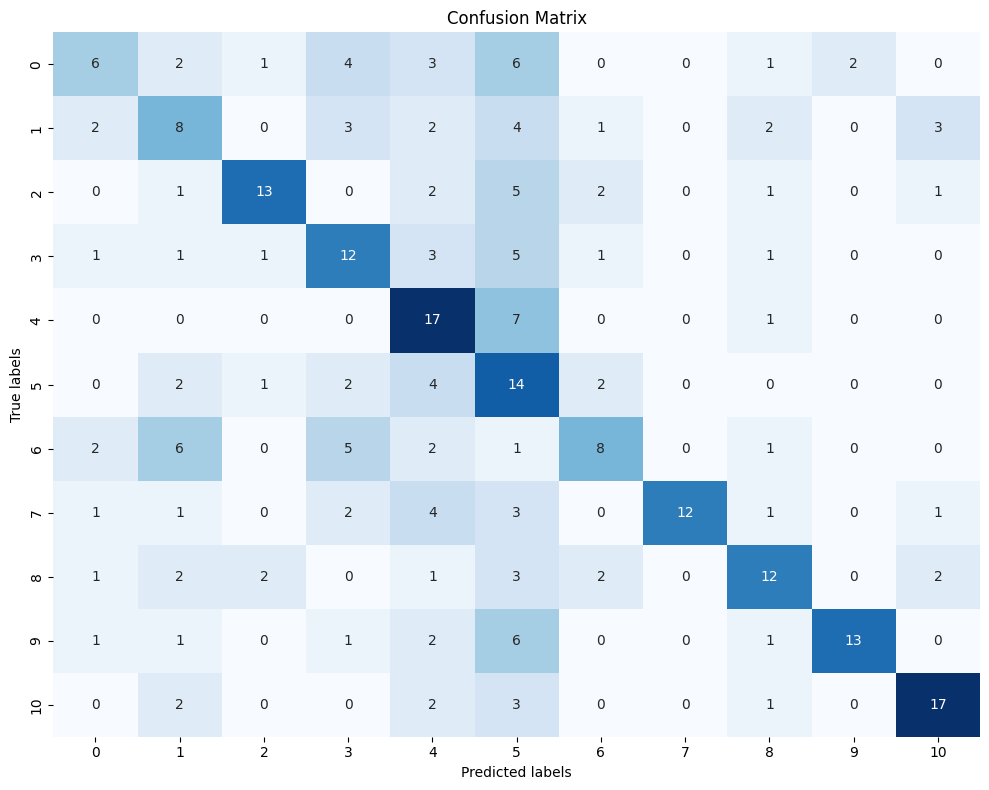

In [32]:
predicted_std_dropout, labels_std_dropout, cm_std_dropout = test_model(std_dropout_00001_32, test_loader_32, criterion, DEVICE)

Evaluating...: 100%|██████████| 9/9 [00:01<00:00,  6.39it/s]


Test Loss: 1.6604, Test Acc: 0.4836


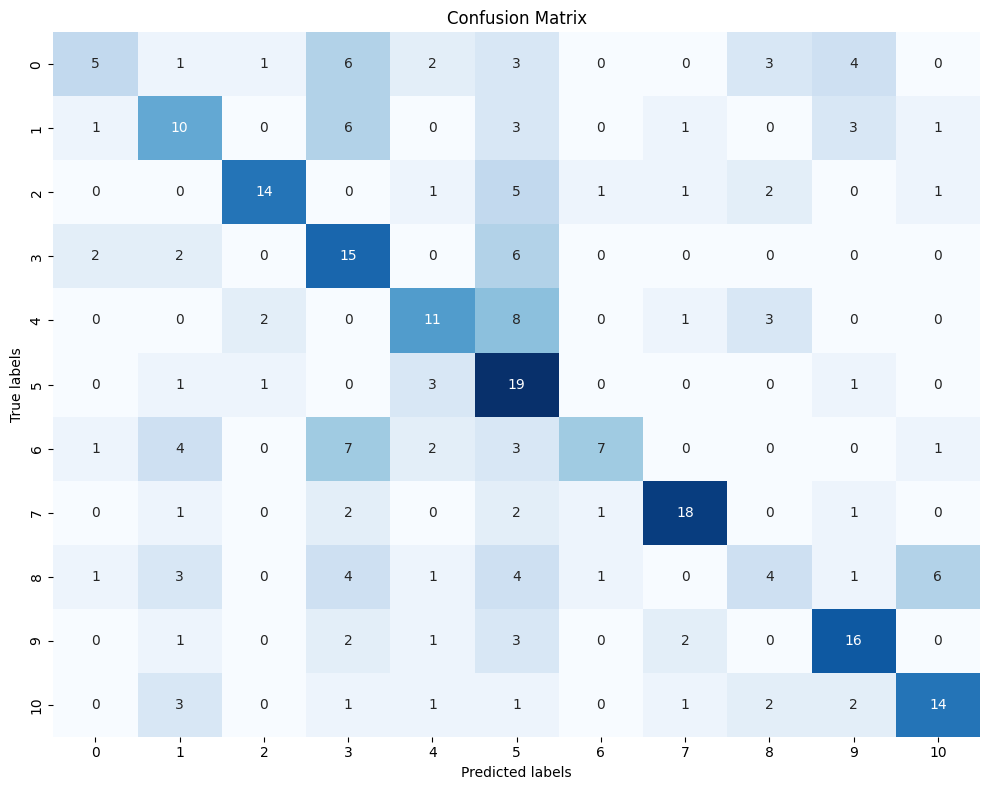

In [33]:
predicted_res_dropout, labels_res_dropout, cm_std_dropout = test_model(res_dropout_00001_64, test_loader_64, criterion, DEVICE)